# Init Tdx 

In [1]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# pip install --upgrade mplfinance
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

In [2]:
# code_list = sina_data.Sina().all.index.tolist()
# print(f'code_list:{len(code_list)}')
# df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start=20170101, end=None,freq=None, col=None, index='date')

In [3]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### ra_diff


In [4]:
def ra_diff(df):
    df['ra_diff'] = df.close.apply(lambda x: round(x / df.close.min(), 2))
    return df

### bullish 测算

In [5]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(10.33, '2025-03-31')

(9.66,
 54    2025-06-20
 Name: date, dtype: object)

9 -0.11 -0.97
Bear
-0.97


### regression_line(X, Y)
regression_ratio(df, window=10):

9.98 0.0
Above
0.0


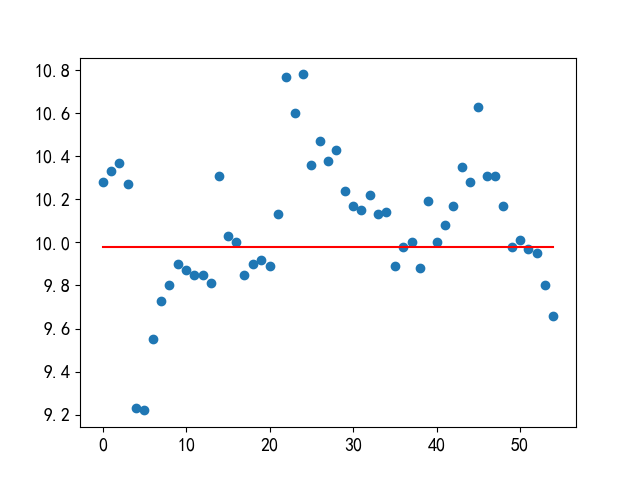

In [6]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

9.98 0.0
Above
0.0


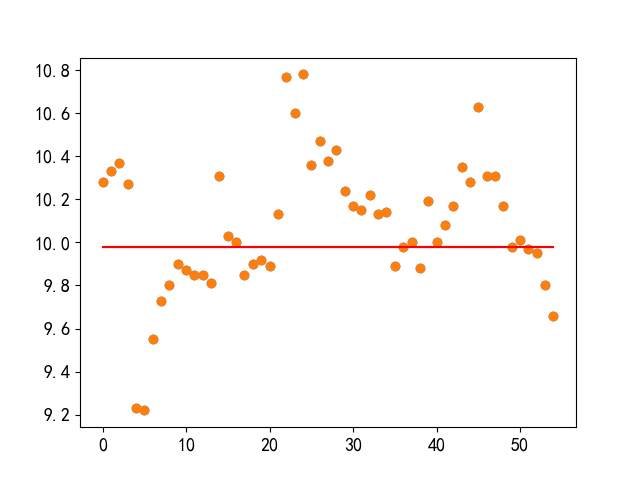

In [7]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [8]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'low4', 'lastdu4', 'macddif', 'macddea', 'macdlast1', 'macdlast2',
       'macdlast3', 'macdlast4', 'macdlast5', 'macdlast6'],
      dtype='object', length=173)

### check_postion_vol_price

In [9]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

date    code  open  high   low  close         vol       amount  \
54  2025-06-20  601360  9.83   9.9  9.65   9.66  41581031.0  404216512.0   

    ma5d  ma10d  ...   lastdu4  macddif  macddea  macdlast1  macdlast2  \
54  9.88  10.08  ...  1.011111    -0.07     -0.0      -0.13       -0.1   

    macdlast3  macdlast4  macdlast5  macdlast6  Positon  
54      -0.08      -0.07      -0.05      -0.03  Neutral  

[1 rows x 174 columns]

In [10]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'lastdu4', 'macddif', 'macddea', 'macdlast1', 'macdlast2', 'macdlast3',
       'macdlast4', 'macdlast5', 'macdlast6', 'Positon'],
      dtype='object', length=174)

0    2025-03-31
1    2025-04-01
2    2025-04-02
Name: date, dtype: object

54   2025-06-20
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

xratio:0.0 
code: 601360


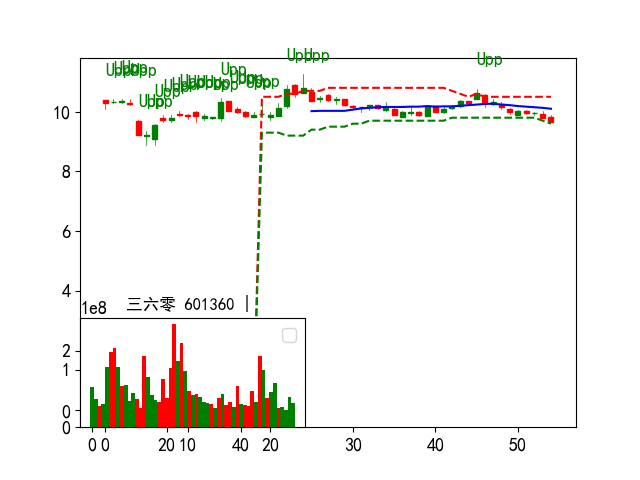

In [11]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    # plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if 'name' not in df.columns and code is not None:
        df['name']= tdd.get_sina_data_code(code)
    if allshow:
        if 'ra_diff' in df.columns:
            print("xratio:%s ra_diff:%s" % (regression_ratio(df),df.ra_diff[-1]))
        else:
            print("xratio:%s " % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    # upper_band = df[df.upper != 0].upper
    # lower_band = df[df.lower != 0].lower
    upper_band = df.upper
    lower_band = df.lower
    
    # print(lower_band,df.lower)
    # print(upper_band,df.upper)

    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(i,lower_band[i])
        #error upper_band ==0.0
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
            
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'g', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(325)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:][0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(str(df.name.values[-1:][0]) + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    print("code:",code)
    plt.show()


show_ohlc_upper(dfc,code=dfc.code[0])

In [12]:
'code' in dfc.columns

True

### show_channel_mpl

In [13]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)

    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [102]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True

def get_multiIndex_drop_last_row(df,dropline=1):

    return df.drop(level='date', labels=df.index.get_level_values('date')[-dropline])

def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df

def clean_sina_dm(dd):
    if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
        dd = dd[dd.close > 0]
    else:
        dd = dd[dd.open > 0]
    return dd

def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None,limit=20,orderby='percent'):
    col_src = [
        "name",'percent', "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]

    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    if orderby in df.columns:
        df=df.sort_values('percent', ascending=False)
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name][:limit]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name][:limit]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name][:limit]
    return temp

def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [15]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.3,
        ma_250_h=1.3, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().all.index.tolist()
#     .Sina().all.index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    print(f'h5_fname:{h5_fname} h5_table:{h5_table}')
#     df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20170501', end=None, freq=None, col=None, index='date')
#     df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
#         freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start=20170101, end=None,freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)
    print(f'df:{df}')
    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration
    if resample != 'd':

        print("resample:%s"%(resample.upper()))
        df = df.groupby(level=0).resample(resample, level=1).last()
        df = df.dropna()
        
    ''' 
    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    #  idx mask filter 
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    '''

    df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据 TDX Days

## resample = 'D'

In [16]:
# resample = 'W-FRI'
resample = 'D'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.2,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

all code: 5197
h5_fname:tdx_all_df_300 h5_table:all_300
df:                      open     high      low    close           vol  \
code   date                                                           
999999 2024-03-20  3058.00  3082.00  3056.00  3080.00  3.491877e+10   
       2024-03-21  3084.00  3090.00  3070.00  3078.00  3.668780e+10   
       2024-03-22  3070.00  3074.00  3028.00  3048.00  3.947405e+10   
       2024-03-25  3040.00  3066.00  3026.00  3026.00  3.874854e+10   
       2024-03-26  3026.00  3036.00  3006.00  3032.00  3.459288e+10   
...                    ...      ...      ...      ...           ...   
301091 2025-06-20    26.66    26.80    26.17    26.23  4.370710e+06   
301285 2025-06-20    29.16    29.95    29.16    29.30  1.470800e+06   
301386 2025-06-20    20.66    20.95    20.41    20.50  1.112172e+06   
300308 2025-06-20   130.00   131.12   124.75   129.50  4.930052e+07   
300101 2025-06-20    21.00    21.19    20.41    20.48  1.905900e+07   

                 

In [17]:
# df.loc['399001'][-1:]
df.loc['000002'][-1:]
# df.groupby(level=[0]).tail(30).groupby(level=[0]).tail(2)
# df.groupby(level=[0]).tail(30).groupby(level=[0]).head(1)

open  high   low  close         vol       amount
date                                                        
2025-06-20  6.33  6.34  6.28   6.29  52448488.0  330716448.0

### Test InStock

In [18]:
df.loc['301083'][:2]

open   high    low  close        vol      amount
date                                                         
2024-03-20  15.41  15.53  15.24  15.43  6056930.0  93843040.0
2024-03-21  15.42  15.56  15.11  15.43  5771594.0  89267952.0

## ra_diff

In [19]:
tail_days = 60

In [20]:
df = df.groupby(level=[0]).tail(tail_days).groupby(level=[0]).apply(ra_diff)


In [21]:
# df.loc['999999'][-3:]
# df.loc['301073'].ra_diff[-3:]
df.loc['300459'].shape

(60, 7)

## X df_regression_ratio outdate
    df_idx_detect

In [22]:
# df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
# df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
# show_ohlc_upper()
# df[:10]

In [23]:
# df_idx_detect.shape, df_idx_detect.loc['000002']
# df.loc['000002'][-2:],df_reg_ratio.loc['000002']
# df.loc['688798'][-3:]

In [24]:
# df.loc['000002'][-10:]

## sina_dm

In [25]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday,sina_dm.name[:1]
sina_dm = clean_sina_dm(sina_dm)

('2025-06-20',
 code
 002196    方正电机
 Name: name, dtype: object)

In [26]:
cct.get_time_to_date(time.time(), format='%Y-%D %H:%M:%S')

# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]
# dm.ticktime[:1]
# sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

'2025-06/22/25 15:31:32'

code
000538   2025-06-22 15:00:00
831641   2025-06-22 15:30:00
Name: ticktime, dtype: datetime64[ns]

1.5444226662317913

### Combine ratio and idx

In [27]:
# if 'date' in df.columns:
#     print('error duplicated date col')
#     if isinstance(df,pd.MultiIndex):
#         df.drop('date', axis=1, inplace=True)
# else:
#     df = df.reset_index().set_index('code')
#     df['idx'] = df_idx_detect
#     df['xratio'] = df_reg_ratio
#     df['name'] = sina_dm.name
#     df = df.reset_index().set_index(['code', 'date'])

## 读取实时成交量数据

In [28]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df

def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if root is None and store is not None:
        root = store.keys()[0].replace("/", "")
    df = store[root]
    df = apply_col_toint(df)
    store.close()
    return df

In [29]:
# tdx_path = "G:\\tdx_last_df.h5"
# from JohnsonUtil import commonTips as cct
sina_MultiD_path = f"{cct.get_ramdisk_dir()}\\sina_MultiIndex_data.h5".replace('\\',os.sep)
print(f'sina_MultiD_path:{sina_MultiD_path}')
h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
h5.shape
h5code='603019'
h5.loc[h5code][-3:]
code_muti = '603019'
# h5.loc[code_muti][:2]

freq = 'D'
# freq = '5M'
startime = '09:25:00'
endtime = '15:01:00'

time_ratio = cct.get_work_time_ratio()
time_ratio
run_col = ['close', 'volume']
# run_col = ['close']
mdf = cct.get_limit_multiIndex_freq(
    h5, freq=freq.upper(),
    col=run_col, start=startime, end=endtime, code=None)
allvol = mdf.volume.sum()
allvol = round(allvol / 10 / 1000 / 1000,2)
print("总量:%s 亿"%(allvol))
mdf['vol']=mdf['volume'].apply(lambda x: round(x /1000/1000,2)) 
mdf['amount']=(mdf.volume * mdf.close).map(lambda x: round(x/100/1000/1000, 2))
#全局占比
mdf['volume'] = mdf.amount.apply(
    lambda x: round(x / allvol * 100 / time_ratio, 2))
mdf=mdf.reset_index().set_index('code')
mdf.loc[h5code]

sina_MultiD_path:/Volumes/RamDisk/sina_MultiIndex_data.h5
['/all_30']
/Volumes/RamDisk/sina_MultiIndex_data.h5


(2767032, 6)

close   high    low  llastp    volume  lastbuy
ticktime                                                           
2025-06-20 14:58:58   66.9  67.88  66.75   67.55  16223684    67.11
2025-06-20 14:59:40   66.9  67.88  66.75   67.55  16223684    67.18
2025-06-20 15:00:01   66.9  67.88  66.75   67.55  16398684    67.07

1.0

总量:8715.97 亿


ticktime    2025-06-21 00:00:00
close                  67.21773
volume                     0.13
vol                        16.4
amount                    11.02
Name: 603019, dtype: object

In [30]:
mdf[:2]
mdf.loc['603019']

ticktime      close  volume     vol  amount
code                                                
000001 2025-06-21  11.804484    0.18  130.92   15.45
000002 2025-06-21   6.307853    0.04   52.45    3.31

ticktime    2025-06-21 00:00:00
close                  67.21773
volume                     0.13
vol                        16.4
amount                    11.02
Name: 603019, dtype: object

In [31]:
# h5.index.get_level_values('code')[0]
# help(h5.index.get_level_values)
str(h5.index.get_level_values(1)[-1])[:10]

'2025-06-20'

In [32]:
if len(mdf) > 0:
    mdf.loc['000002']
else:
    print("mdf is None")

ticktime    2025-06-21 00:00:00
close                  6.307853
volume                     0.04
vol                       52.45
amount                     3.31
Name: 000002, dtype: object

###  实时成交量个股Top!!!

In [33]:
nowdf = mdf.sort_values(by=['volume'], ascending=[0])
# nowdf.shape, df.shape, code_idx.shape
# top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd=get_sina_data_cname(top20_nd)

In [34]:
nowdf.shape,top20_nd

((5420, 5),
         volume   name
 code                 
 300308    0.73   中际旭创
 300468    0.71   四方精创
 600519    0.57   贵州茅台
 300476    0.55   胜宏科技
 300502    0.54    新易盛
 601318    0.53   中国平安
 300773    0.49    拉卡拉
 002475    0.45   立讯精密
 002463    0.45   沪电股份
 002104    0.43   恒宝股份
 000858    0.41  五 粮 液
 300059    0.39   东方财富
 300750    0.38   宁德时代
 003040    0.36    楚天龙
 002384    0.35   东山精密
 002017    0.33   东信和平
 603300    0.32   海南华铁
 300255    0.31   常山药业
 002050    0.31   三花智控
 002594    0.29    比亚迪)

In [35]:
# show_tdx_data(top20_nd)
# top20_nd.columns

### 合并实时成交量及SinaDM

In [36]:
from JSONData import tdx_hdf5_api as h5a
def get_tdx_all_from_h5(resample='d',showtable=True):
    #sina_monitor
    h5_fname = 'tdx_last_df'
    resample=resample
    if resample=='d':
        dl='60'
    else:
        dl='200'
    filter='y'
    h5_table = 'low' + '_' + resample + '_' + str(dl) + '_' + filter + '_' + 'all'
    h5 = h5a.load_hdf_db(h5_fname, table=h5_table,code_l=None, timelimit=False,showtable=showtable)
    return h5


In [37]:
# mdf[:1]
sinadm = cct.combine_dataFrame(sina_dm, mdf[['vol','amount']])
sinadm['percent']=((sinadm['close']-sinadm['llastp'])/(sinadm['llastp'])*100).round(1)

In [38]:
h5tdx = get_tdx_all_from_h5(resample='w')
tdx_now_w = cct.combine_dataFrame(h5tdx,sinadm)

keys:['/low_3d_60_y_all', '/low_d_60_y_all', '/low_m_300_y_all', '/low_w_200_y_all']


In [39]:
tdx_now_w.query('close > lastp1d and lastp1d > lastp2d and lastp2d >lastp3d and close > high4')

lopen  lhigh   llow  lastp         lvol       lamount   ma5d  ma10d  \
code                                                                          
000001  10.64  10.69  10.12  10.53  358023392.0  4.196242e+09  11.38  11.07   
000159   5.17   5.22   4.21   4.91  214715664.0  1.302705e+09   5.72   5.50   
000403  15.88  16.05  15.35  15.62   86129480.0  1.593298e+09  17.33  16.95   
000504   5.65   5.94   5.43   5.71   25983296.0  2.327742e+08   7.74   7.31   
000518   2.04   2.04   1.91   1.91   96055256.0  2.591469e+08   2.33   2.17   
...       ...    ...    ...    ...          ...           ...    ...    ...   
832978  14.04  14.14  13.13  13.26    8462282.0  2.012203e+08  23.72  24.27   
833171   5.95   6.12   5.44   5.61  285157440.0  3.629016e+09  10.96   9.53   
833914  14.42  14.78  13.28  13.38   33019996.0  6.969446e+08  19.69  19.73   
839719   9.00   9.30   8.81   8.81   71969408.0  1.381858e+09  16.09  13.71   
872895  12.22  12.40  11.91  11.94    5892150.0  2.302504e+08  33.62  26.77   

        ma20d  ma60d  ...  close         nvol  lastbuy   nlow  nhigh  nclose  \
code                  ...                                                      
000001  11.10    0.0  ...  11.84  130919782.0    11.80  11.67  11.75   11.80   
000159   5.50    0.0  ...   6.54  110508374.0     6.61   6.29   6.74    6.61   
000403  16.59    0.0  ...  18.31   13573499.0    18.33  18.16  18.38   18.33   
000504   8.54    0.0  ...   8.98    6750103.0     8.90   8.61   8.88    8.90   
000518   2.34    0.0  ...   2.67   20212440.0     2.66   2.59   2.68    2.66   
...       ...    ...  ...    ...          ...      ...    ...    ...     ...   
832978  21.08    0.0  ...  24.53    3207847.0    24.36  23.89  24.47   24.36   
833171   7.72    0.0  ...  13.62   84832108.0    13.62  12.35  13.03   13.62   
833914  18.05    0.0  ...  23.78   13844062.0    23.50  21.70  23.80   23.50   
839719  12.08    0.0  ...  23.70   30956138.0    22.64  20.59  23.64   22.64   
872895  19.59    0.0  ...  52.53    4404682.0    48.81  40.16  43.66   48.81   

        nstd     vol  amount  percent  
code                                   
000001  -2.0  130.92   15.45      1.2  
000159  -2.0  110.51    7.30      1.1  
000403  -2.0   13.57    2.49      0.2  
000504  -2.0    6.75    0.60      2.2  
000518  -2.0   20.21    0.54      1.9  
...      ...     ...     ...      ...  
832978  -2.0    3.10    0.75      1.4  
833171  -2.0   83.34   11.35      7.1  
833914  -2.0   13.71    3.22      8.3  
839719  -2.0   30.18    6.83     15.7  
872895  -2.0    4.40    2.17     30.0  

[139 rows x 220 columns]

### tdx_last_df and Now sina!!! RealTIME

In [40]:
tdx_h5=get_tdx_all_from_h5()
tdx_now = cct.combine_dataFrame(tdx_h5,sinadm)

keys:['/low_3d_60_y_all', '/low_d_60_y_all', '/low_m_300_y_all', '/low_w_200_y_all']


In [104]:
tdx_now.shape
# tdx_now.query('close >  lastp1d  and lastl1d < ma51d and close > ma51d and lastp1d < upper and lastp1d > lastp2d and lasth1d >high4 and boll > 0 and volume < 1')
tdx_select = tdx_now.query('close > lastp1d and percent < 3')[:10]
show_tdx_data(tdx_select,limit=10)

(5403, 221)

Count:10 221


name  percent        date  close   hmax   lmin  perc1d  nclose  \
code                                                                      
000065   北方国际      1.9  2025-04-08   9.87  11.48   9.99    -1.1    9.80   
000001   平安银行      1.2  2025-04-07  11.84  11.79  10.63     0.0   11.80   
000049   德赛电池      0.3  2025-04-08  21.58  21.73  20.91     1.2   21.72   
000056   皇庭国际      0.3  2025-04-07   3.02   3.34   3.03    -1.1    3.02   
000058  深 赛 格      0.3  2025-04-08   7.90   8.59   7.96    -1.1    7.91   
000088  盐 田 港      0.2  2025-04-07   4.48   5.24   4.42    -0.1    4.49   
000011   深物业A      0.1  2025-04-08   8.21   8.75   8.26    -0.1    8.21   
000028   国药一致      0.1  2025-04-07  24.84  26.09  24.66    -0.1   24.86   
000039   中集集团      0.1  2025-04-08   7.72   8.39   7.66     0.0    7.70   
000048   京基智农      0.1  2025-04-18  15.72  18.72  15.59     0.0   15.67   

         llow  perc3d  perc5d  
code                           
000065   9.24     0.1    -0.1  
000001  10.12     1.2     1.2  
000049  19.17     1.3    -0.1  
000056   3.00     0.2    -0.1  
000058   7.04     0.3    -1.1  
000088   4.23     0.0     0.0  
000011   7.35     0.1    -0.1  
000028  23.69     0.0    -0.1  
000039   7.23     0.0     1.3  
000048  14.85     0.1    -0.1

In [105]:
tdx_now.query('close.isna()').buy
# tdx_h5.loc['301397']
tdx_filter = tdx_now.query('low < ma5d*1.01 and close > max5 and close >hmax and percent > 1 and close > upper and boll > 1 and not code.str.contains("688")')

show_tdx_data(tdx_filter)

code
399005   NaN
399001   NaN
399006   NaN
999999   NaN
300959   NaN
          ..
688726   NaN
688750   NaN
688757   NaN
688758   NaN
000584   NaN
Name: buy, Length: 225, dtype: float64

Count:27 221


name  percent        date  close   hmax   lmin  perc1d  nclose   llow  \
code                                                                            
300462  华铭智能     13.2  2025-04-08  11.56  10.30   9.32    -1.1   11.18   7.45   
603209  兴通股份     10.0  2025-04-08  16.44  15.24  14.13    -0.1   16.27  13.46   
002930  宏川智慧     10.0  2025-04-30  11.91  10.71   9.21    -1.1   11.77   9.04   
601121  宝地矿业     10.0  2025-04-08   6.28   6.05   5.77    -0.1    6.12   5.29   
600773  西藏城投     10.0  2025-04-28   9.97   9.17   8.68     0.2    9.40   8.75   
002506  协鑫集成      9.9  2025-04-29   2.55   2.43   2.17    -1.1    2.55   2.08   
833171  国航远洋      7.1  2025-04-07  13.62  13.45   6.78     0.0   13.62   5.38   
300252   金信诺      6.4  2025-04-07  11.09  10.72   9.66    -0.9   10.55   8.38   
300142  沃森生物      6.1  2025-04-29  11.08  10.79  10.01    -1.1   11.03   9.84   
600199  金种子酒      5.7  2025-04-29  11.00  10.56   9.77     0.0   10.94   9.51   
603125  常青科技      5.6  2025-04-08  15.74  15.58  14.33    -0.1   15.43  12.00   
000985  大庆华科      5.2  2025-04-08  20.38  18.23  17.09    31.8   19.94  14.56   
601778  晶科科技      4.9  2025-04-07   2.81   2.71   2.59    -0.1    2.75   2.56   
300801  泰和科技      4.8  2025-04-07  18.03  17.06  15.52    26.0   17.70  13.86   
300057  万顺新材      4.7  2025-04-07   5.14   4.95   4.66     0.0    5.14   3.94   
300887  谱尼测试      3.9  2025-04-07   8.52   8.02   6.96    -1.0    8.52   6.41   
001296  长江材料      3.8  2025-04-08  20.34  20.31  17.09     0.0   20.58  14.70   
601975  招商南油      3.3  2025-04-30   3.15   2.87   2.69     0.0    3.07   2.67   
002352  顺丰控股      3.1  2025-04-07  50.66  49.81  42.78    -0.1   50.75  39.28   
301117  佳缘科技      3.0  2025-04-29  20.83  20.38  18.69     0.0   20.50  16.23   

        perc3d  perc5d  
code                    
300462    1.20    -0.1  
603209    0.10     0.2  
002930   30.30     0.0  
601121   -1.10     1.3  
600773    0.00     0.0  
002506   28.41     0.2  
833171   24.91    21.5  
300252    0.10    -1.1  
300142    1.30    -1.1  
600199    1.30     0.0  
603125   -0.10     1.3  
000985    0.00     1.3  
601778    1.30     0.0  
300801    0.00    -0.9  
300057    1.20    -1.1  
300887   20.50    13.1  
001296   -0.90     1.3  
601975   29.20    10.6  
002352    1.20     1.2  
301117    0.10    -1.1

#### 新高test!!!!!!

In [43]:
# write_code_to_blk(tdx_filter.index.tolist(),'rqg')

write blk [Y] or [N]:n


True

In [44]:
sinadm.shape
sinadm.columns
# sinadm['percent']=((sinadm['close']-sinadm['llastp'])/(sinadm['llastp'])*100).round(1)
# sinadm['percent'] = sinadm['percent'].round(1)
sinadm.query('percent > 6 ')

(5180, 45)

Index(['name', 'open', 'llastp', 'now', 'trade', 'high', 'low', 'buy', 'sell',
       'volume', 'turnover', 'b1_v', 'b1', 'b2_v', 'b2', 'b3_v', 'b3', 'b4_v',
       'b4', 'b5_v', 'b5', 'a1_v', 'a1', 'a2_v', 'a2', 'a3_v', 'a3', 'a4_v',
       'a4', 'a5_v', 'a5', 'dt', 'ticktime', 'b1_vv', 'close', 'nvol', 'timel',
       'lastbuy', 'nlow', 'nhigh', 'nclose', 'nstd', 'vol', 'amount',
       'percent'],
      dtype='object')

name   open  llastp    now  trade   high    low    buy   sell  \
code                                                                    
688093  世华科技  26.80   26.78  28.91    0.0  30.00  26.66  28.91  28.91   
300142  沃森生物  10.48   10.44  11.08    0.0  11.31  10.46  11.07  11.08   
002930  宏川智慧  10.75   10.83  11.91    0.0  11.91  10.66  11.91   0.00   
300655  晶瑞电材   8.50    8.53   9.49    0.0   9.85   8.50   9.49   9.50   
300804  广康生化  56.59   56.44  60.88    0.0  62.59  54.59  60.88  60.88   
...      ...    ...     ...    ...    ...    ...    ...    ...    ...   
872895  花溪科技  40.28   40.41  52.53    0.0  52.53  40.16  52.53   0.00   
603212  赛伍技术  10.49    9.66  10.63    0.0  10.63  10.49  10.63   0.00   
603198  迎驾贡酒  38.69   38.56  41.31    0.0  41.34  38.56  41.31  41.34   
688313  仕佳光子  36.38   36.09  38.59    0.0  39.94  35.88  38.59  38.59   
600773  西藏城投   9.04    9.06   9.97    0.0   9.97   9.03   9.97   0.00   

           volume  ...       nvol         timel  lastbuy   nlow  nhigh  \
code               ...                                                   
688093    6637191  ...    6637191  1.750577e+09    27.89  26.66  27.38   
300142  105806911  ...  105806911  1.750577e+09    11.03  10.46  10.66   
002930   30345602  ...   30345602  1.750577e+09    11.77  10.66  10.99   
300655  163616487  ...  163616487  1.750577e+09     9.38   8.50   9.07   
300804    6311421  ...    6311421  1.750577e+09    59.88  54.59  59.94   
...           ...  ...        ...           ...      ...    ...    ...   
872895    4404682  ...    4404682  1.750577e+09    48.81  40.16  43.66   
603212   15475183  ...   15475183  1.750577e+09    10.63  10.49  10.63   
603198   25688837  ...   25688837  1.750577e+09    40.59  38.56  39.66   
688313   50266786  ...   50266786  1.750577e+09    38.25  35.88  39.00   
600773   41603642  ...   41603642  1.750577e+09     9.40   9.03   9.15   

        nclose  nstd     vol  amount  percent  
code                                           
688093   27.89  -2.0    6.64    1.85      8.0  
300142   11.03  -2.0  105.81   11.67      6.1  
002930   11.77  -2.0   30.35    3.58     10.0  
300655    9.38  -2.0  163.62   15.35     11.3  
300804   59.88  -2.0    6.31    3.78      7.9  
...        ...   ...     ...     ...      ...  
872895   48.81  -2.0    4.40    2.17     30.0  
603212   10.63  -2.0   15.48    1.64     10.0  
603198   40.59  -2.0   25.69   10.43      7.1  
688313   38.25  -2.0   50.27   19.23      6.9  
600773    9.40  -2.0   41.60    3.91     10.0  

[80 rows x 45 columns]

## check HDF LastDate

In [45]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

#今日的code
df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape

#没有今日的code
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(0, 7)

(4924, 7)

In [46]:
# df_tail1

In [47]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

open    high     low   close          vol        amount  \
code   date                                                                    
999999 2025-06-20  3358.0  3370.0  3358.0  3360.0  350223648.0  4.108733e+11   

                   ra_diff  
code   date                 
999999 2025-06-20     1.09

In [48]:
# df.info()
# code_t = '600519'
# print(dfNow.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()
# df[(df.idx > df.idx.shift(1)) & (df.xratio > df.xratio.shift(1))].shape


## reindex sort date

In [49]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [50]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2

if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']
        

def init_MulitiData_Roll(df,resample='d',duration=300):
    time_s = time.time()
    dfs = df.copy()
    # dfs = df.loc['600519']
    # groupd = dfs.groupby(level=[0])
    # groupd.['close']
    # rollma = ['5','10','60','100','200']
    # rollma = ['5','10','250']
    # df.index.get_level_values('code')[0]
    if resample.upper() == 'D' or resample.lower() == 'd':
        if duration < 300:
            rollma = ['10', '5', '20']
        else:
            rollma = ['10', '5', '20', '250']

    elif resample.upper() == 'W' or resample.lower() == 'w':
        rollma = ['5', '10','20']
    else:
        rollma = ['5', '10','20']

    # rollma.extend([str(duration)])

    # import ipdb;ipdb.set_trace()
    # df.loc['300130'][:2]

    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # BOLL:MA(CV,N), COLORMAGENTA;
    # UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
    # LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
    # df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
    # df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
    for da in rollma:
        cumdays = int(da)
        dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

        # dfs['upper'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 + 11.0 / 100) * x, 1))
        # dfs['lower'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 - 9.0 / 100) * x, 1))
        # dfs['boll'] = list(map(lambda x, y: round(
        #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
    if duration > 100:
        dfs['upper'] = round(
            dfs['close'].rolling(20).mean() + 2 *
            dfs['close'].rolling(20).std(),
            2)
        dfs['lower'] = round(
            dfs['close'].rolling(20).mean() - 2 *
            dfs['close'].rolling(20).std(),
            2)

        dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

        dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
        dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

        dfs['hat'] = dfs['upper'] - dfs['lower']

        # dfs['hmax'] = round(dfs['close'].cummax(), 2)


    dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
    dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
    dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

    return dfs
# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [51]:
dfsRoot=init_MulitiData_Roll(df,resample=resample)

### DFS MutiIndex Test 0507

In [52]:
# dfs.loc['000002'][-5:].upper
dfsRoot.loc['603357'][-5:][['close','upper','low','boll']][-2:]
dftemp = dfsRoot.loc['603357']
dftemp[dftemp.close > dftemp.upper][:2]
print(dftemp.shape)

close  upper   low  boll
date                                
2025-06-19   8.47   8.67  8.45  8.51
2025-06-20   8.47   8.66  8.44  8.50

Empty DataFrame
Columns: [open, high, low, close, vol, amount, ra_diff, ma10, ma5, ma20, ma250, upper, lower, boll, hmax, lmin, hat, perc1d, perc2d, perc3d, perc4d, perc5d, vol1d, vol2d, vol3d, vol4d, vol5d, volsum5d]
Index: []

[0 rows x 28 columns]

(60, 28)


In [106]:
# dfs.loc['688027']
dfsRoot['ma51d'] = round(dfsRoot['close'].rolling(5).mean(), 2)
show_tdx_data(dfsRoot.loc['600519'][-2:],col=['ma51d','ra_diff'])
# show_tdx_data(dfs.loc['600519'])

Count:2 29


ra_diff     hat   close  volsum5d    hmax    lmin  perc1d    ma20  \
date                                                                            
2025-06-19      1.0  216.38  1426.0      20.0  1596.0  1401.0    0.07  1501.7   
2025-06-20      1.0  212.14  1429.0     -29.2  1588.0  1401.0    0.21  1494.1   

             ma250  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  perc5d   ma51d  \
date                                                                            
2025-06-19  379.45 -20.35  12.96 -36.51 -27.45  91.35    0.28   -3.65  1425.4   
2025-06-20  385.11  42.10 -20.35  12.96 -36.51 -27.45    0.14    0.14  1425.8   

            ra_diff  
date                 
2025-06-19      1.0  
2025-06-20      1.0

### Append Now SinaTo MultiIndex dfNow

In [54]:
# tail_days = 60
# cct.get_today()
def get_Append_Sina_To_MultiTDX(df,sina_dm):
    if cct.get_work_time_duration():
        sina_today=sina_dm.copy()
        if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
            sina_today['date']=pd.to_datetime(cct.get_today())
            print('concat1 init:sina_today:%s'%(sina_today.index[0]))
            # df_reg_ratio2 = df.groupby(level=[0])['close'].apply(regression_ratio)
            # df_idx_detect2 = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
            # sina_today['idx'] = df_idx_detect2
            # sina_today['xratio'] = df_reg_ratio2
            # sina_today=sina_today.loc[:,['open','high','low','close','date','idx',y'xratio']].reset_index().set_index(['code', 'date'])
            if 'vol' in sina_today.columns:
                sina_today=sina_today.loc[:,['open','high','low','close','vol','amount','name','date']].reset_index().set_index(['code', 'date'])
            else:
                sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])

        if sina_today.index[0] not in df.index:
            # df.index=df.index.append(sina_dm.index)
            print('concat1:sina_today:%s %s'%(sina_today.index[0]))
            df = pd.concat([df, sina_today])


    #         sina_today=sina_dm.copy()
    #         #drop line and append idx
    #         if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
    #             sina_today['date']=pd.to_datetime(cct.get_today())
    #             print('concat2 init:sina_today:%s'%(sina_today.index[0]))

    #             sina_today['idx'] = df_idx_detect2
    #             sina_today['xratio'] = df_reg_ratio2
    #             sina_today=sina_today.loc[:,['open','high','low','close','date','name','idx','xratio']].reset_index().set_index(['code', 'date'])
    #             # sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])   


    #         df = get_multiIndex_drop_last_row(df,dropline=1)

            if sina_today.index[0] not in df.index:
                # df.index=df.index.append(sina_dm.index)
                print('concat2:sina_today:%s %s'%(sina_today.index[0]))
                df = pd.concat([df, sina_today])
            df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
    return df

# dfNow=get_Append_Sina_To_MultiTDX(df.groupby(level=[0]).tail(30),sina_dm)


if resample.upper() == 'D':
    dfsRoot=get_Append_Sina_To_MultiTDX(dfsRoot.groupby(level=[0]).tail(tail_days),sinadm)
    dfNow= dfsRoot.groupby(level=[0]).tail(tail_days/2)
    
    dfNow=init_MulitiData_Roll(dfNow,resample=resample,duration=20)
else:
    dfNow = dfsRoot.groupby(level=[0]).tail(tail_days/2).copy()
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
# df[-2:]
dfNow[-2:]

open   high    low  close          vol        amount  \
code   date                                                                
000001 2025-06-19  11.76  11.78  11.65  11.70   83224720.0  9.741274e+08   
       2025-06-20  11.70  11.86  11.67  11.84  130919784.0  1.544542e+09   

                   ra_diff   ma10    ma5   ma20  ...  perc3d  perc4d  perc5d  \
code   date                                      ...                           
000001 2025-06-19     1.09  11.74  11.73  11.65  ...   -0.85    0.86   -1.27   
       2025-06-20     1.11  11.75  11.77  11.67  ...    0.68    0.34    2.07   

                   vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  
code   date                                                            
000001 2025-06-19  21.76 -23.20 -24.22   7.21   0.08     -18.4  11.73  
       2025-06-20  57.31  21.76 -23.20 -24.22   7.21      38.9  11.77  

[2 rows x 29 columns]

In [55]:
dfsRoot.groupby(level=[0]).tail(60).loc['000002'][-1:]


open  high   low  close         vol       amount  ra_diff  ma10  \
date                                                                          
2025-06-20  6.33  6.34  6.28   6.29  52448488.0  330716448.0      1.0   6.5   

             ma5  ma20  ...  perc3d  perc4d  perc5d  vol1d  vol2d  vol3d  \
date                    ...                                                
2025-06-20  6.44  6.57  ...   -3.68    -4.7   -1.72 -38.62  34.49    9.1   

            vol4d  vol5d  volsum5d  ma51d  
date                                       
2025-06-20 -55.28  48.64      -1.7   6.44  

[1 rows x 29 columns]

### Xratio and tail 60 MultiIndex 

In [56]:
## dfNow['xratio'] = dfNow['close'].rolling(30).apply(regression_ratio)
if 'xratio' not in dfNow.columns:
    df_xratio = dfNow.groupby(level=[0])['close'].rolling(24).apply(regression_ratio)
    df_xratio.index =df_xratio.to_frame().index.droplevel(1)
    dfNow['xratio'] = df_xratio

In [57]:
# df_xratio.loc['605589'][-8:]
dfsRoot.loc['603019'][:1]
# dfNow[-12:][-2:]

open   high    low  close         vol        amount  ra_diff  \
date                                                                       
2025-03-07  73.5  73.94  71.62  72.06  37972536.0  2.763343e+09     1.21   

             ma10   ma5   ma20  ...  perc3d  perc4d  perc5d    vol1d  vol2d  \
date                            ...                                           
2025-03-07  15.26  21.6  12.09  ...   688.4  691.87  709.66  1161.63 -55.31   

            vol3d  vol4d   vol5d  volsum5d  ma51d  
date                                               
2025-03-07   27.7  -39.5  159.84    1254.4   21.6  

[1 rows x 29 columns]

## DFNow Query check

In [58]:
dfNow_A = dfNow.query('@dfNow.index.get_level_values(0) < "688000"')
# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')
# dfNow.groupby(level=[0]).tail(3)
lastworkday = cct.last_tddate(1)
print(lastworkday)
# dfxra.groupby(level=[0]).tail(1).query('date >= @lastworkday').xratio
# dfxra.query('@dfxra.index.get_level_values(0) < "688000"')
# dfxra.query('not @dfxra.index.get_level_values(0).str.contains("688") ')

# df.query(f'ColumnName >= {VariableName}')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('0 > xratio > -0.08 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio > 0 and xratio.shift(1) < 0 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

dfxra = dfNow_A.groupby(level=[0]).tail(3).query('high > upper  and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))')

dfxra.query('date >= @lastworkday').sort_values(by='xratio',ascending=0).xratio[:10]
# dfxra.query('date >= @lastworkday').xratio[:10]

# dfxra.query('date >= @lastworkday').loc['605589'].xratio
df_xratio.loc['605369'][-8:]

2025-06-20


code    date      
003040  2025-06-20    0.40
300841  2025-06-20    0.34
300130  2025-06-20    0.32
002352  2025-06-20    0.25
300950  2025-06-20    0.19
002741  2025-06-20    0.18
003017  2025-06-20    0.16
605389  2025-06-20    0.16
300816  2025-06-20    0.15
600113  2025-06-20    0.14
Name: xratio, dtype: float64

date
2025-06-10     NaN
2025-06-11   -0.03
2025-06-13   -0.04
2025-06-16   -0.06
2025-06-17   -0.08
2025-06-18   -0.09
2025-06-19   -0.11
2025-06-20   -0.12
Name: close, dtype: float64

In [59]:
# dfNow['idx'] = dfNow['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx = dfNow.groupby(level=[0])['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx.index =df_idx.to_frame().index.droplevel(1)
dfNow['idx'] = df_idx

### dfNow Top

date
2025-06-19    5.75
2025-06-20    5.75
Name: upper, dtype: float64

(60, 29)
xratio:-0.0 ra_diff:1.19
code: 300459


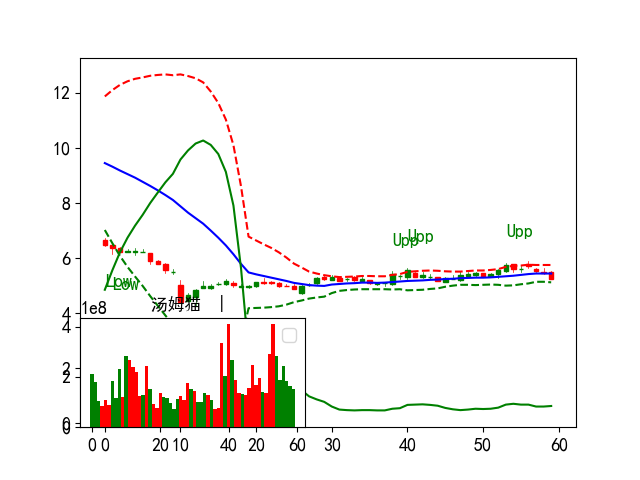

In [60]:
dfNow.loc['300459'][-2:].upper
print(dfsRoot.loc['300459'][-tail_days:].shape)
show_ohlc_upper(dfsRoot.loc['300459'][-tail_days:],code='300459')

In [61]:
# '302132' in dfsRoot.index

300308
xratio:0.43 ra_diff:1.8
code: 300308


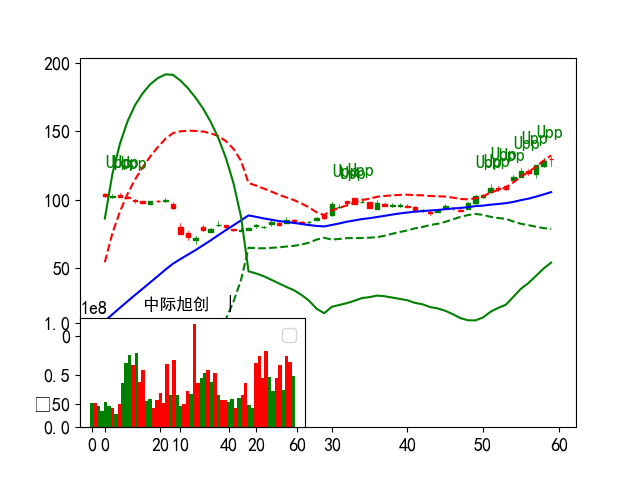

300468
xratio:0.28 ra_diff:2.58
code: 300468


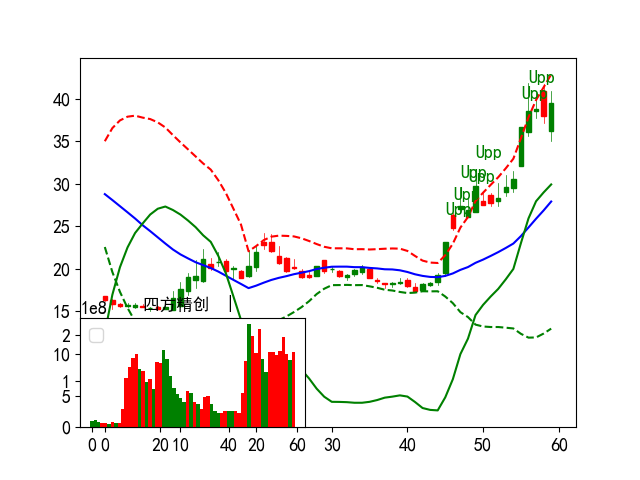

In [62]:
for co in top20_nd.index[:2]:
    print(co)
    # show_ohlc_upper(dfs.loc[co][-30:],co)
    if co in dfsRoot.index:
        show_ohlc_upper(dfsRoot.loc[co][-tail_days:],co)
    else:
        print(f'code:{co} not find in dfsRoot')

In [63]:
code_df = '600519'
dfNow_t2 = dfNow.groupby(level=[0]).tail(2)
# dfNow_f = dfNow_t2[ (dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) ]
idx = pd.IndexSlice
mask_df =  ((dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) )

dfNow_t2 = dfNow_t2.loc[idx[mask_df, :]]

group250 = dfNow_t2.groupby(level=[0])
dfNow_f = group250.tail(1).reset_index().set_index('code')
mask_df = (dfNow_f.date >= cct.get_today())
dfNow_f = dfNow_f.loc[idx[mask_df, :]]
dfNow_f[:2]

Empty DataFrame
Columns: [date, open, high, low, close, vol, amount, ra_diff, ma10, ma5, ma20, ma250, upper, lower, boll, hmax, lmin, hat, perc1d, perc2d, perc3d, perc4d, perc5d, vol1d, vol2d, vol3d, vol4d, vol5d, volsum5d, ma51d, xratio, idx]
Index: []

[0 rows x 32 columns]

In [64]:
# dfNow_f.shape,dfNow_f[:3],dfNow_t2.loc['600812'],df.loc['600812'][-2:]
# dfNow_f[dfNow_f.date >= cct.get_today()]
# dfNow_f.loc['000006']
# dfNow_t2.loc['000006']
# (dfNow_t2.loc[code_df].idx > dfNow_t2.loc[code_df].idx.shift(1)) 
# (dfNow_t2.loc[code_df].xratio > dfNow_t2.loc[code_df].xratio.shift(1))
# dfNow_f.loc[code_df],dfNow.loc[code_df]

### pandas multiinde drop last row

In [65]:
df.loc['000002'][-2:]

open  high   low  close         vol       amount  ra_diff
date                                                                 
2025-06-19  6.42  6.43  6.30   6.32  85454624.0  542431808.0      1.0
2025-06-20  6.33  6.34  6.28   6.29  52448488.0  330716448.0      1.0

In [66]:
dfNow.loc['000002'][-2:]

open  high   low  close         vol       amount  ra_diff  ma10  \
date                                                                          
2025-06-19  6.42  6.43  6.30   6.32  85454624.0  542431808.0      1.0  6.53   
2025-06-20  6.33  6.34  6.28   6.29  52448488.0  330716448.0      1.0  6.50   

             ma5  ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  vol5d  \
date                    ...                                              
2025-06-19  6.46  6.60  ...   -3.81  34.49   9.10 -55.28  48.64 -11.54   
2025-06-20  6.44  6.57  ...   -1.72 -38.62  34.49   9.10 -55.28  48.64   

            volsum5d  ma51d  xratio   idx  
date                                       
2025-06-19      25.4   6.46   -0.01 -0.32  
2025-06-20      -1.7   6.44   -0.02 -0.31  

[2 rows x 31 columns]

# 基础处理

In [67]:
# show_tdx_data(dfs.loc['600519'][-2:])
dfs = dfNow.fillna(0)
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s %s' % (dt_low,dt[0]))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    dfs_dtlen[-2:]
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    # print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
# dfs_dtlen.loc['999999'].reset_index().date
lastday_week = dfs_dtlen.loc['999999'].reset_index().date[0]
lastday_week
# dfs_dtlen[('ma%s') % (rollma[-1])][-2:]
# print(df_idx)

dt_low:2025-05-27 2025-06-20


open   high    low  close          vol        amount  \
code   date                                                                
000001 2025-06-19  11.76  11.78  11.65  11.70   83224720.0  9.741274e+08   
       2025-06-20  11.70  11.86  11.67  11.84  130919784.0  1.544542e+09   

                   ra_diff   ma10    ma5   ma20  ...  perc5d  vol1d  vol2d  \
code   date                                      ...                         
000001 2025-06-19     1.09  11.74  11.73  11.65  ...   -1.27  21.76 -23.20   
       2025-06-20     1.11  11.75  11.77  11.67  ...    2.07  57.31  21.76   

                   vol3d  vol4d  vol5d  volsum5d  ma51d  xratio   idx  
code   date                                                            
000001 2025-06-19 -24.22   7.21   0.08     -18.4  11.73    0.02  0.03  
       2025-06-20 -23.20 -24.22   7.21      38.9  11.77    0.02  0.14  

[2 rows x 31 columns]

Low:2025-05-27


Timestamp('2025-05-27 00:00:00')

In [68]:
time_s = time.time()
# rollma

def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("dt_low:%s df:%s %s df_idx:%s" %
                  (dt_low,len(df_mask), df_mask.index[:5], len(df_idx))))


                
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            if len(df_mask) > 0:
                if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                    idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                    # df_mask = df_mask.loc[idx_set_, :].dropna()
                df_mask = df_mask.sort_values(by='couts', ascending=1)
                df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            else:
                print("df_mask is None:%s"%(len(df_mask)))
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s  %s" %
                    (round(time.time() - time_s, 2), len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
  #      top_temp = top_temp[(~top_temp.index.str.contains(
  #          '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(9948, 31)
count dd.couts
(code    date      
688668  2025-05-27    17
603373  2025-05-27    17
601009  2025-05-27    17
301369  2025-05-27    17
301345  2025-05-27    17
Name: couts, dtype: int64, (9948, 32))
dt_low:2025-05-27 df:267 Index(['688668', '603373', '601009', '301369', '301345'], dtype='object', name='code') df_idx:686
Main Down dd :28 MainUP df:267 couts std:4.3 
time: 0.19  216


In [69]:
dfs_dtlen.loc['002987'][-1:]

open   high    low  close         vol       amount  ra_diff  \
date                                                                       
2025-06-20  14.82  15.01  14.05  14.66  56440636.0  817492736.0     1.21   

            ma10    ma5  ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  \
date                           ...                                       
2025-06-20  14.6  14.87  14.0  ...    6.23 -25.97 -11.08   6.92   9.66   

             vol5d  volsum5d  ma51d  xratio  idx  
date                                              
2025-06-20  132.64     112.2  14.87    0.13 -0.1  

[1 rows x 31 columns]

## 最近60天筛选

In [70]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(tail_days)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# dfs_tail[dfs_tail.ra_diff > 2]

### filter mask250 get_level_values

In [108]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)
# df_mask250 = df_mask250[df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10] ]
# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
df_mask250 = df_mask250.sort_values(
        by=['ra_diff','hat', 'couts'],
        ascending=[0,0, 0])
show_tdx_data(df_mask250)

(958, 31)
count dd.couts
(code    date      
002983  2025-05-08    16
Name: couts, dtype: int64, (958, 32))
(code    date      
002983  2025-06-19    16
600000  2025-06-20    14
Name: couts, dtype: int64, (280, 32))
Count:280 32


couts  ra_diff  xratio   idx    hat  close  volsum5d  \
code   date                                                               
688313 2025-05-19      2     2.25    0.00  0.00  19.88  31.09       3.6   
300871 2025-05-22      3     2.00    0.00  0.00   6.42  24.52       7.4   
603665 2025-06-11      3     1.83    0.31  0.00   7.81  26.05     109.2   
002549 2025-06-03      3     1.71    0.00  0.00   2.63  10.42       8.8   
300095 2025-06-10      2     1.64    0.00  0.00   1.70   9.30     268.2   
603906 2025-06-19      2     1.62    0.18  1.25   5.00  14.48     -58.0   
002734 2025-05-23      1     1.62    0.00  0.00   3.51  15.93      97.3   
603680 2025-06-16      2     1.60    0.12  1.10   4.24  11.50      64.3   
600415 2025-06-19      7     1.60    0.14  1.03   4.08  19.47     148.3   
300947 2025-06-18      4     1.59    0.06  0.41   3.75  22.55      46.9   
300703 2025-05-26      2     1.58    0.00  0.00   4.73  17.48     207.6   
003005 2025-05-19      8     1.58    0.00  0.00   2.96  29.81     -21.3   
300542 2025-06-18      2     1.56    0.11  1.84   3.78  21.67      72.2   
603586 2025-06-11      1     1.56    0.03  0.00   1.52  19.09      46.0   
002537 2025-06-06      1     1.55    0.00  0.00   2.96   8.02     693.7   
301013 2025-05-28      3     1.53    0.00  0.00   4.67  19.80      89.2   
688379 2025-05-27      9     1.52    0.00  0.00   8.47  29.42     126.0   
603042 2025-06-11      1     1.52    0.16  0.00   7.40  16.59     241.0   
300468 2025-05-29      1     1.51    0.00  0.00   4.87  23.11     224.9   
300382 2025-05-15      1     1.50    0.00  0.00   5.51  14.37     -20.1   

                    hmax   lmin  perc1d   ma20  ma250  vol1d   vol2d   vol3d  \
code   date                                                                    
688313 2025-05-19  33.28  14.91   -1.24  30.00  29.78 -17.23   39.23  -34.07   
300871 2025-05-22  28.19  20.72   -9.35  22.74  22.61 -22.08  -10.15  100.02   
603665 2025-06-11  27.98  19.48    5.98  24.11  24.83  -7.65   25.62   83.38   
002549 2025-06-03  11.62   8.42    2.16   9.78   9.50 -20.67  -16.71  -29.49   
300095 2025-06-10  10.40   8.21   -2.62   8.79   8.47 -25.83   -8.46  325.56   
603906 2025-06-19  16.11  11.14    0.28  13.31  13.51  -7.97  -18.43   41.26   
002734 2025-05-23  16.00  12.14    4.80  15.07  15.05  37.28   -0.10  -29.97   
603680 2025-06-16  14.00   9.66    0.00  10.78  10.62 -20.78  -60.68   -6.50   
600415 2025-06-19  20.12  16.70   -1.57  18.17  18.01 -39.52   95.91    8.29   
300947 2025-06-18  24.38  19.69   -3.47  21.70  20.76  -8.35  -14.05    9.88   
300703 2025-05-26  19.94  13.83    2.10  16.44  16.18  14.73  -22.14  -39.52   
003005 2025-05-19  31.98  28.77    0.98  29.31  28.64 -12.62  -37.52   41.02   
300542 2025-06-18  22.41  18.20   -1.77  20.12  20.34 -34.70   33.68   27.70   
603586 2025-06-11  19.09  17.09   10.09  17.85  18.32  27.51    5.36   36.47   
002537 2025-06-06   9.16   6.53   -7.82   7.40   7.49 -21.34   -2.46   32.82   
301013 2025-05-28  21.14  14.10    6.34  19.72  18.20  68.49   98.41  -40.98   
688379 2025-05-27  32.16  22.84   -2.13  28.07  27.06 -26.28  -23.85   22.21   
603042 2025-06-11  20.80  13.41   -9.74  15.11  15.91 -17.16   -7.53    6.45   
300468 2025-05-29  23.11  17.41   19.93  21.16  22.21  92.39  149.75  -17.47   
300382 2025-05-15  15.38  11.20   -1.03  13.68  13.16 -16.81   -1.05  -11.47   

                    vol4d   vol5d  perc3d  perc5d  
code   date                                        
688313 2025-05-19   39.92  -24.20    4.72    7.28  
300871 2025-05-22  -33.46  -26.96    4.25   -2.54  
603665 2025-06-11   -3.54   11.39    0.27    1.09  
002549 2025-06-03  101.89  -26.25   -3.96    1.56  
300095 2025-06-10    6.90  -29.94   11.38    9.80  
603906 2025-06-19  -30.75  -42.09    0.56   -1.76  
002734 2025-05-23   29.09   61.00    8.07   11.40  
603680 2025-06-16   12.08  140.15  -12.61   -0.09  
600415 2025-06-19   16.17   67.48    1.99    3.56  
300947 2025-06-18   39.73   19.66  

limit_output extension: Maximum message size of 10000 exceeded with 10550 characters

#### filter today

In [72]:
df_mask250  = df_mask250[(df_mask250.xratio > 0) & (df_mask250.index.get_level_values('date') > cct.get_today() )]
# df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape


In [73]:
# df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10]

#### debug ra_diff4

In [74]:
dfs.loc['301073'][-5:].ra_diff

date
2025-06-16    1.11
2025-06-17    1.13
2025-06-18    1.16
2025-06-19    1.16
2025-06-20    1.18
Name: ra_diff, dtype: float64

xratio:-0.01 ra_diff:1.0
code: 000002


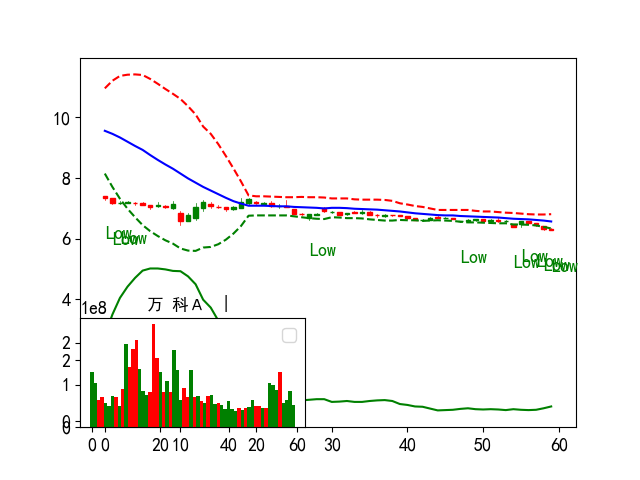

In [75]:
# dfs.loc['000002'][-60:]
show_ohlc_upper(dfsRoot.loc['000002'][-60:],code='000002')
for co in df_mask250.index.get_level_values(0)[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-tail_days:],code=co)

## 最近60天数据

In [76]:
dfs_tail9 = dfs.groupby(level=[0]).tail(tail_days)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

In [77]:
dfs_tail9.loc[(['999999','399001','399006'],'ra_diff')].groupby(level=0).tail(3)
# dfs_tail9.loc[pd.IndexSlice[['999999','399001','399006'], :, :]].tail(3)
# dfs_tail9.query(("code == '999999'" and "date > '2023-04-01'"))

code    date      
999999  2025-06-18    1.09
        2025-06-19    1.09
        2025-06-20    1.09
399001  2025-06-18    1.09
        2025-06-19    1.07
        2025-06-20    1.07
399006  2025-06-18    1.14
        2025-06-19    1.12
        2025-06-20    1.11
Name: ra_diff, dtype: float64

## 超跌反弹年线大于MA20

In [109]:
# show_tdx_data(dfs_tail9.loc['300418'])[-2:]
show_tdx_data(dfs_tail9.loc['603131'])
# print(dfs_tail9.loc['603131',['high','upper','hmax']])

Count:30 31


ra_diff  xratio  idx   hat  close  volsum5d  hmax   lmin  perc1d  \
date                                                                           
2025-05-08     1.15     0.0  0.0  2.34  17.62     283.2  18.0  14.39   47.94   
2025-05-09     1.16     0.0  0.0  2.34  17.73     390.0  18.5  14.39    0.62   
2025-05-12     1.18     0.0  0.0  2.58  18.09     417.8  18.5  15.70    2.03   
2025-05-13     1.15     0.0  0.0  2.62  17.62     299.1  18.5  15.70   -2.60   
2025-05-14     1.14     0.0  0.0  2.64  17.45     301.0  18.5  15.70   -0.96   
2025-05-15     1.12     0.0  0.0  2.62  17.05       6.1  18.5  15.70   -2.29   
2025-05-16     1.12     0.0  0.0  2.58  17.11     -94.2  18.5  15.70    0.35   
2025-05-19     1.12     0.0  0.0  2.40  17.09    -105.4  18.5  15.70   -0.12   
2025-05-20     1.12     0.0  0.0  2.20  17.08     -52.7  18.5  15.99   -0.06   
2025-05-21     1.10     0.0  0.0  2.06  16.84      20.8  18.5  15.99   -1.41   
2025-05-22     1.09     0.0  0.0  2.06  16.62      -2.6  18.5  15.99   -1.31   
2025-05-23     1.08     0.0  0.0  2.06  16.44      39.1  18.5  15.99   -1.08   
2025-05-26     1.09     0.0  0.0  2.08  16.62       8.8  18.5  15.99    1.09   
2025-05-27     1.10     0.0  0.0  2.06  16.88      66.3  18.5  15.99    1.56   
2025-05-28     1.09     0.0  0.0  2.08  16.69     -11.4  18.5  15.99   -1.13   
2025-05-29     1.12     0.0  0.0  1.88  17.09     226.7  18.5  15.99    2.40   
2025-05-30     1.12     0.0  0.0  1.75  17.14     203.0  18.5  16.23    0.29   
2025-06-03     1.12     0.0  0.0  1.65  17.19     223.9  18.5  16.39    0.29   
2025-06-04     1.13     0.0  0.0  1.65  17.30     166.8  18.5  16.39    0.64   
2025-06-05     1.19     0.0  0.0  1.90  18.17     342.3  18.5  16.39    5.03   

             ma20  ma250   vol1d   vol2d   vol3d   vol4d   vol5d  perc3d  \
date                                                                       
2025-05-08  12.12  12.78  293.17  -36.23   82.74  -24.14  -32.35   44.66   
2025-05-09  12.44  12.80   74.41  293.17  -36.23   82.74  -24.14   48.12   
2025-05-12  12.77  12.82    3.71   74.41  293.17  -36.23   82.74   51.89   
2025-05-13  13.08  12.83  -35.93    3.71   74.41  293.17  -36.23    0.00   
2025-05-14  13.38  12.85  -34.36  -35.93    3.71   74.41  293.17   -1.58   
2025-05-15  13.65  12.86   -1.68  -34.36  -35.93    3.71   74.41   -5.75   
2025-05-16  13.93  12.88  -25.97   -1.68  -34.36  -35.93    3.71   -2.89   
2025-05-19  14.21  12.89   -7.42  -25.97   -1.68  -34.36  -35.93   -2.06   
2025-05-20  14.48  12.91   16.72   -7.42  -25.97   -1.68  -34.36    0.18   
2025-05-21  14.73  12.93   39.19   16.72   -7.42  -25.97   -1.68   -1.58   
2025-05-22  14.96  12.94  -25.10   39.19   16.72   -7.42  -25.97   -2.75   
2025-05-23  15.18  12.95   15.76  -25.10   39.19   16.72   -7.42   -3.75   
2025-05-26  15.42  12.96  -37.73   15.76  -25.10   39.19   16.72   -1.31   
2025-05-27  15.65  12.98   74.20  -37.73   15.76  -25.10   39.19    1.56   
2025-05-28  15.87  12.99  -38.56   74.20  -37.73   15.76  -25.10    1.52   
2025-05-29  16.11  13.01  213.01  -38.56   74.20  -37.73   15.76    2.83   
2025-05-30  16.36  13.02   -7.93  213.01  -38.56   74.20  -37.73    1.54   
2025-06-03  16.61  13.04  -16.83   -7.93  213.01  -38.56   74.20    3.00   
2025-06-04  16.88  13.05   17.11  -16.83   -7.93  213.01  -38.56    1.23   
2025-06-05  17.19  13.07  136.90   17.11  -16.83   -7.93  213.01    6.01   

            perc5d  
date                
2025-05-08   44.43  
2025-05-09   45.45  
2025-05-12   48.52  
2025-05-13   47.20  
2025-05-14   46.52  
2025-05-15   -3.23  
2025-05-16   -3.50  
2025-05-19   -5.53  
2025-05-20   -3.06  
2025-05-21   -3.50  
2025-05-22   -2.52  
2025-05-23   -3.92  
2025-05-26   -2.75  
2025-05-27   -1.17  
2025-05-28   -0.89  
2025-05-29    2.83  
2025-05-30    4.26  
2025-06-03    3.43  
2025-06-04    2.49  
2025-06-05    8.87

## !!! Run-Filter强势Upper

### !!! filterRule test

In [79]:
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9,resample=resample):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    if resample.upper()=='D':
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])",
                 "(dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99)"]
    else:
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])"]
    col_rule_tail4=[ "(dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))",
             "(dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))"]
    
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)
    col_rule.extend(col_rule_tail3)
    col_rule.extend(col_rule_tail4)
    
    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')



30
9 -0.01 -0.12


'Bear'

-0.12

date
2025-06-16    0.0
2025-06-17   -0.0
2025-06-18   -0.0
2025-06-19   -0.0
2025-06-20   -0.0
Name: xratio, dtype: float64

xratio:0.0 ra_diff:1.05
code: 601728


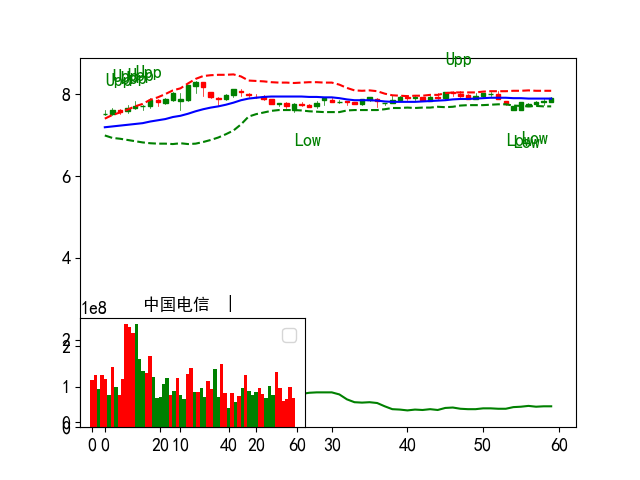

In [80]:
code_filter = '601728'

print(len(dfs_tail9.loc[code_filter]))

# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)

dfs.loc[code_filter].xratio[-5:]

# filter_rule_Test(dfs_tail9.loc[code_filter])

show_ohlc_upper(dfsRoot.loc[code_filter][-60:], code=code_filter)



In [81]:
# dfs.loc['300474'][-5:]

### 新高Hmax日见新高df_mask_hmax

#### hmax 追高 TEST

30
xratio:0.02 ra_diff:1.14
code: 600012


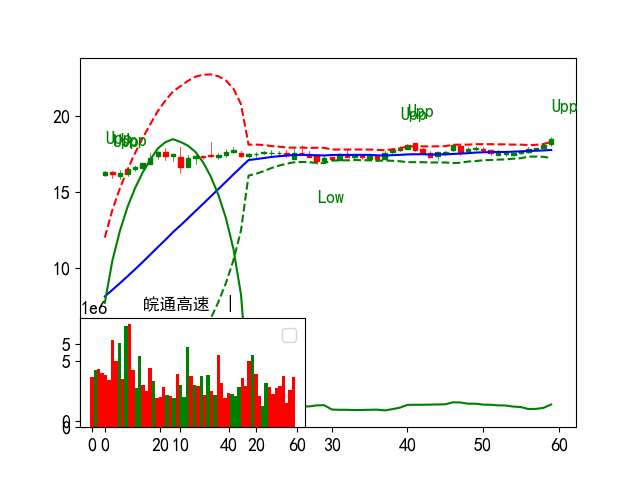

In [82]:
code='600012'
print(len(dfs_tail9.loc[code]))
# show_tdx_data(dfs_tail9.loc[code],col='upper')
show_ohlc_upper(dfsRoot.loc[code],code=code)

In [110]:

# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ((dfs_tail9[('hmax')] > 0) &

if resample.upper() =='D':
    mask_hmax = ( (dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(1)) &
                 ((dfs_tail9[('high')] >= dfs_tail9[('hmax')])) &
                 (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99))
                 # (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99) &
                 # (dfs_tail9[('close')] < dfs_tail9.ma250 * 1.05))
else:
    mask_hmax = ( (dfs_tail9[('low')] >= dfs_tail9[('ma5')].shift(1))  &
              (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1))  ) 

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & (dfs_tail9[('close')] > dfs_tail9.ma20 *0.99) & (dfs_tail9[('close')] < dfs_tail9.ma20 *1.20) )


df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)

# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

# df_mask_hmax.couts.std()

df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts','volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0,0, 0, 0, 0])
    # by=['volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0, 0, 0, 0])
# print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['300461'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax)
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)]).T

count dd.couts
compute percent


(code
 601009    17
 Name: couts, dtype: int64,
 (81, 41))

Count:81 41


name  couts       date   perc  ra_diff  xratio    idx    hat   close  \
code                                                                            
601009   南京银行     17 2025-06-20   1.86     1.19    0.06   0.76   1.50   12.05   
600919   江苏银行     16 2025-06-20   0.34     1.28    0.05   0.73   1.39   11.88   
600000   浦发银行     15 2025-06-20   2.20     1.35    0.03   0.70   0.94   13.02   
300308   中际旭创     12 2025-06-20   0.97     1.80    1.57  26.06  53.85  129.50   
600926   杭州银行     11 2025-06-20   2.75     1.23    0.07   0.64   1.63   17.16   
002940    昂利康     11 2025-06-20   9.95     2.58    0.83  12.32  25.34   31.94   
600036   招商银行     10 2025-06-20   0.83     1.14    0.10   1.53   3.50   46.00   
002741   光华科技      9 2025-06-20   6.07     1.42    0.18   2.25   5.73   19.41   
002352   顺丰控股      9 2025-06-20   3.05     1.26    0.25   3.75   6.57   50.66   
301132   满坤科技      8 2025-06-20   4.41     1.61    0.15   5.41   7.34   33.41   
603209   兴通股份      8 2025-06-20  10.04     1.20    0.03   1.43   1.70   16.44   
002270   华明装备      8 2025-06-20   1.68     1.31    0.07   1.89   3.09   17.52   
002057   中钢天源      8 2025-06-20   6.00     1.25    0.03   0.55   1.04    8.84   
300093  *ST金刚      8 2025-06-20   4.09     1.90    0.16   0.67   3.98   13.22   
600673    东阳光      8 2025-06-20  -1.02     1.31    0.08   1.45   3.04   11.60   
603722    阿科力      8 2025-06-20   0.34     1.29    0.24   6.72  10.75   44.06   
002805   丰元股份      7 2025-06-20   3.45     1.29    0.04   1.57   1.95   13.50   
000504  *ST生物      7 2025-06-20   2.16     1.57    0.10   1.22   3.51    8.98   
000985   大庆华科      7 2025-06-20   5.16     1.36    0.06   2.58   3.05   20.38   
603306   华懋科技      7 2025-06-20   1.06     1.50    0.34   2.50   8.98   43.84   

        volsum5d  ...  ma250  nclose    llow   vol1d   vol2d   vol3d   vol4d  \
code              ...                                                          
601009      11.9  ...   7.65   11.99   11.82   43.57  -17.17    9.77  -14.74   
600919      58.2  ...  10.41   11.84   11.71   72.38   30.18  -22.90   -0.38   
600000      64.8  ...  12.14   12.95   12.73   59.46  -37.34   86.93  -26.85   
300308      45.7  ...  28.84  128.38  124.75  -21.21   -7.74   89.33  -39.66   
600926      36.1  ...   9.45   17.09   16.72   44.09   24.03  -22.74   45.99   
002940     -40.1  ...  17.00   31.53   27.06  -24.00  -27.09  -18.70   35.48   
600036      -0.6  ...  23.44   45.97   45.56  -12.72   20.41  -10.08   14.41   
002741     133.5  ...   9.61   19.41   18.09   50.54   27.80  -33.22   71.05   
002352      45.1  ...  21.97   50.75   49.44   52.59    8.30   -5.30  -27.71   
301132     863.4  ...  22.03   33.62   31.66   11.34   44.37  842.67  -23.52   
603209     405.9  ...  13.17   16.27   14.80  328.44    1.96  -23.51  137.90   
002270     236.6  ...  13.76   17.66   17.20    6.37   31.59  -21.70  169.44   
002057     163.6  ...   6.71    8.83    8.55  236.16  -14.01   -1.63  -21.58   
300093      72.2  ...   6.51   13.26   12.62   17.29   22.38   80.68  -16.79   
600673      29.3  ...   8.41   11.66   11.46   -3.12  -14.21    0.64  -31.23   
603722       1.0  ...  20.35   44.06   43.47   26.95  -12.06   -1.74   -4.71   
002805     480.6  ...   9.93   13.68   12.81  209.89  271.19   -9.09  -16.72   
000504     276.8  ...   5.79    8.90    8.61   25.37  -20.03  -41.32  379.79   
000985     229.9  ...  17.82   19.94   18.44    9.41  276.32  -35.93   13.29   
603306     150.7  ...  21.96   43.62   42.81  -49.21  -13.82  198.41  -10.94   

        vol5d  perc3d  perc5d  
code                           
601009  -9.50    2.64    2.99  
600919 -21.09    2.06    3.30  
600000 -17.40    3.83    5.85  
300308  25.02    8.48   11.04  
600926 -55.25    4.51    4.00  
002940  -5.74   10.06   21.44  
600036 -12.57    0.07    1.79  
002741  17.34    5.72    9.66  
002352  17.23    1.95    3.39  
301132 -11.47   18.94   19.32  
603209 -38.84    7.45    9.60  
002270  50.95    2.10   10.19  
002057 -35.39    

limit_output extension: Maximum message size of 10000 exceeded with 10846 characters

#### !!! hmax Top upper > 1

In [84]:
# dfs_tail9.loc['600103']

In [111]:
# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) ) )
# mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) )
if resample.upper() == 'D':
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )
else:
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )

df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]

#站上Upper
# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')



df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
 # by=['volsum5d', 'idx', 'hat', 'perc1d'],
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['000039'])
df_mask_hmax.couts[:1], df_mask_hmax.shape

# show_tdx_data(df_mask_hmax).T
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)])
show_tdx_data(df_mask_hmax.query('couts >= 1 and perc >2  and   low < ma5 '),limit=10 )

count dd.couts
compute percent
code
002940    11
Name: couts, dtype: int64 (99, 41)


(code
 002940    11
 Name: couts, dtype: int64,
 (99, 41))

Count:30 41


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
002940   昂利康     11 2025-06-20   9.95     2.58    0.83  12.32  25.34  31.94   
003040   楚天龙     10 2025-06-20  10.05     2.11    0.40   7.75  12.63  23.33   
600000  浦发银行      9 2025-06-20   2.20     1.35    0.03   0.70   0.94  13.02   
300340  科恒股份      7 2025-06-20  20.00     2.58    0.45   7.54  14.93  20.64   
603256  宏和科技      6 2025-06-20   9.97     1.89    0.16   2.06   4.75  13.68   
002057  中钢天源      6 2025-06-20   6.00     1.25    0.03   0.55   1.04   8.84   
300490  华自科技      6 2025-06-20   5.85     1.32    0.02   0.00   1.06   8.50   
002741  光华科技      5 2025-06-20   6.07     1.42    0.18   2.25   5.73  19.41   
300410  正业科技      5 2025-06-20  19.97     1.80    0.04   1.40   1.50   7.45   
300847  中船汉光      5 2025-06-20   2.35     1.26    0.01   1.04   1.10  17.45   

        volsum5d  ...  ma250  nclose   llow   vol1d   vol2d  vol3d  vol4d  \
code              ...                                                       
002940     -40.1  ...  17.00   31.53  27.06  -24.00  -27.09 -18.70  35.48   
003040      62.0  ...  26.77   21.95  19.09    1.28   82.42 -19.13  16.53   
600000      64.8  ...  12.14   12.95  12.73   59.46  -37.34  86.93 -26.85   
300340      86.5  ...  11.55   19.86  16.41   16.48   57.31 -27.25  71.37   
603256     135.1  ...  35.22   12.77  12.11   19.01   26.62  36.05 -13.86   
002057     163.6  ...   6.71    8.83   8.55  236.16  -14.01  -1.63 -21.58   
300490     205.2  ...  32.46    8.47   8.10  156.17   46.54   8.27  29.72   
002741     133.5  ...   9.61   19.41  18.09   50.54   27.80 -33.22  71.05   
300410     191.6  ...  11.74    7.43   6.19  142.43   11.92  11.59   1.40   
300847     180.9  ...  19.97   17.17  16.48   27.96  169.37   2.92   4.09   

        vol5d  perc3d  perc5d  
code                           
002940  -5.74   10.06   21.44  
003040 -19.11   28.19   36.51  
600000 -17.40    3.83    5.85  
300340 -31.37   17.94   30.63  
603256  67.31   14.86   22.14  
002057 -35.39    1.96    1.61  
300490 -35.53    5.20    7.59  
002741  17.34    5.72    9.66  
300410  24.21   21.53   24.17  
300847 -23.47    4.05    5.76  

[10 rows x 24 columns]

In [86]:
# show_tdx_data(df_mask_hmax.loc['600103'][-5:])

##### sort_values

In [112]:
show_tdx_data(
    df_mask_hmax.query('perc > 1').sort_values(
        by=['ra_diff', 'couts', 'idx'],
        ascending=[0, 0, 0]),col='ra_diff')

Count:76 41


name  couts       date   perc  ra_diff  ra_diff  xratio    idx    hat  \
code                                                                            
002940   昂利康     11 2025-06-20   9.95     2.58     2.58    0.83  12.32  25.34   
300340  科恒股份      7 2025-06-20  20.00     2.58     2.58    0.45   7.54  14.93   
300483  首华燃气      3 2025-06-20  10.99     2.19     2.19    0.14   5.45   6.21   
003040   楚天龙     10 2025-06-20  10.05     2.11     2.11    0.40   7.75  12.63   
301040  中环海陆      4 2025-06-20   4.49     2.09     2.09    0.01   4.86   6.51   
300269  联建光电      4 2025-06-20  13.21     2.04     2.04    0.05   2.10   2.36   
002235  安妮股份      6 2025-06-20   9.99     2.03     2.03    0.13   3.34   4.55   
603256  宏和科技      6 2025-06-20   9.97     1.89     1.89    0.16   2.06   4.75   
300410  正业科技      5 2025-06-20  19.97     1.80     1.80    0.04   1.40   1.50   
600110  诺德股份      4 2025-06-20  10.04     1.71     1.71    0.04   1.47   1.92   
601606  长城军工      6 2025-06-20  10.01     1.70     1.70    0.09   4.96   5.20   
002579  中京电子      2 2025-06-20   9.99     1.67     1.67    0.07   2.84   3.16   
600113  浙江东日      4 2025-06-20   9.99     1.64     1.64    0.14   6.75   7.50   
301132  满坤科技      3 2025-06-20   4.41     1.61     1.61    0.15   5.41   7.34   
301292  海科新源      1 2025-06-20  20.06     1.60     1.60    0.16   8.40   8.43   
603928  兴业股份      2 2025-06-20  10.01     1.51     1.51    0.09   2.87   3.89   
603306  华懋科技      6 2025-06-20   1.06     1.50     1.50    0.34   2.50   8.98   
300589  江龙船艇      2 2025-06-20  20.00     1.50     1.50    0.05   3.54   3.38   
300812  易天股份      2 2025-06-20   4.69     1.47     1.47    0.06   1.45   2.47   
301152  天力锂能      2 2025-06-20   3.74     1.46     1.46    0.11   4.77   5.42   

        close  ...  ma250  nclose   llow   vol1d   vol2d   vol3d   vol4d  \
code           ...                                                         
002940  31.94  ...  17.00   31.53  27.06  -24.00  -27.09  -18.70   35.48   
300340  20.64  ...  11.55   19.86  16.41   16.48   57.31  -27.25   71.37   
300483  14.85  ...  12.74   14.76  13.31   53.94   37.77  -23.25   -3.11   
003040  23.33  ...  26.77   21.95  19.09    1.28   82.42  -19.13   16.53   
301040  27.20  ...  26.79   26.45  25.67   39.83  -15.26   -7.54   58.77   
300269   6.17  ...   8.42    6.01   5.31   -5.26   41.31  322.45   98.61   
002235   9.03  ...   9.87    8.88   8.21  -23.84    7.63   15.27   -5.71   
603256  13.68  ...  35.22   12.77  12.11   19.01   26.62   36.05  -13.86   
300410   7.45  ...  11.74    7.43   6.19  142.43   11.92   11.59    1.40   
600110   5.15  ...  14.85    5.15   4.89  -48.45   34.89  170.03  173.60   
601606  18.36  ...  10.53   18.12  16.50  -17.43  125.62   32.60   32.22   
002579  10.90  ...  10.08   10.90  10.72  884.27  -76.49  299.86  -31.33   
600113  20.69  ...  11.76   19.38  18.00  -12.22   86.66   43.46  189.63   
301132  33.41  ...  22.03   33.62  31.66   11.34   44.37  842.67  -23.52   
301292  23.52  ...  25.10   23.52  21.30    9.57  228.12  -21.57  447.84   
603928  13.74  ...  20.41   13.55  12.71   36.01   48.86  -36.47  -36.44   
603306  43.84  ...  21.96   43.62  42.81  -49.21  -13.82  198.41  -10.94   
300589  15.12  ...  10.39   14.25  12.30  123.67   95.56   52.59   17.84   
300812  22.75  ...  21.82   22.16  21.58  160.93    3.30  138.57  -13.95   
301152  28.58  ...  33.25   27.75  26.44    0.50  687.03   -5.31    0.94   

         vol5d  perc3d  perc5d  
code                            
002940   -5.74   10.06   21.44  
300340  -31.37   17.94   30.63  
300483    9.97   29.58   35.00  
003040  -19.11   28.19   36.51  
301040   -5.18   11.80   27.04  
300269   14.05   47.96   50.49  
002235  942.91   23.19   30.87  
603256   67.31   14.86   22.14  
300410   24.21   21.53   24.17  
600110  -53.49   33.42   47.14  
601606  -18.02   33.14   37.01  
002579  -40.40   33.09   32.93  
600113   50.54   30.54   47.79  
301132  -11.47   18.94   19.32  
301292  -31.34   44.03  

limit_output extension: Maximum message size of 10000 exceeded with 10762 characters

xratio:-0.06 ra_diff:1.0
code: 300540


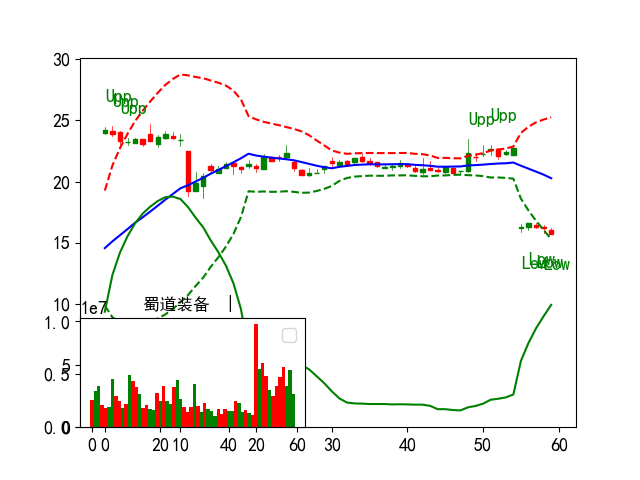

In [88]:
show_ohlc_upper(dfsRoot.loc['300540'][-60:],code='300540')

### !!! df_mask250 upper xratio

In [113]:

if resample.upper() =='D':
    mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
                (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                                 (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
               (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
elif resample.upper() =='W' or resample == 'W-FRI':
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
else:
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
              )

# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250.shape
#站上Upper
df_mask250 = df_mask250[ (df_mask250[('close')] > df_mask250.upper)]

df_mask250 = get_multi_code_count(df_mask250)


code_t = '603131'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)



# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
print("df_mask250:%s df_mask_hmax:%s"%(len(df_mask250),len(df_mask_hmax)))
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_mask250.loc[cross_hmax_250].query('couts > 1 and perc > 0'))
# show_tdx_data(df_mask250.query('couts > 1 and perc > 0')[:20])
# show_tdx_data(df_mask250.loc[code_t])

(569, 31)

count dd.couts
(code    date      
002207  2025-06-13    5
        2025-06-16    5
        2025-06-17    5
Name: couts, dtype: int64, (380, 32))
compute percent
df_mask250:224 df_mask_hmax:99
cross_hamx:26
Count:9 41


name  couts       date   perc  ra_diff  xratio    idx    hat   close  \
code                                                                           
300308  中际旭创      2 2025-06-16   0.97     1.68    0.75  27.06  34.65  129.50   
002940   昂利康      2 2025-06-16   9.95     2.34    0.57  13.94  19.49   31.94   
600113  浙江东日      3 2025-06-20   9.99     1.64    0.14   6.75   7.50   20.69   
301200  大族数控      2 2025-06-20   0.99     1.29    0.02   5.62   8.00   42.03   
301132  满坤科技      2 2025-06-20   4.41     1.61    0.15   5.41   7.34   33.41   
601606  长城军工      2 2025-06-20  10.01     1.70    0.09   4.96   5.20   18.36   
601869  长飞光纤      2 2025-06-20   4.04     1.29    0.13   3.65   6.55   38.59   
002270  华明装备      3 2025-06-20   1.68     1.31    0.07   1.89   3.09   17.52   
002119  康强电子      2 2025-06-18   1.22     1.20    0.02   1.83   2.00   16.62   

        volsum5d  ...  ma250  nclose    llow  vol1d   vol2d    vol3d   vol4d  \
code              ...                                                          
300308      56.3  ...  26.92  128.38  116.88  25.02   38.43   -28.41  -34.08   
002940     324.7  ...  16.75   31.53   25.70  -5.74  -43.82   460.04  -40.77   
600113     358.1  ...  11.76   19.38   18.00 -12.22   86.66    43.46  189.63   
301200     990.7  ...  34.59   42.19   41.34 -18.37   -4.37  1035.37  -15.30   
301132     863.4  ...  22.03   33.62   31.66  11.34   44.37   842.67  -23.52   
601606     155.0  ...  10.53   18.12   16.50 -17.43  125.62    32.60   32.22   
601869     436.8  ...  17.54   38.69   36.34  22.01  389.99    -3.32  -45.50   
002270     236.6  ...  13.76   17.66   17.20   6.37   31.59   -21.70  169.44   
002119     426.9  ...   8.06   16.62   16.02  16.90  110.83   -24.35  -45.14   

         vol5d  perc3d  perc5d  
code                            
300308   55.31   11.94   16.61  
002940  -45.06   22.21   47.81  
600113   50.54   30.54   47.79  
301200   -6.62   16.56   17.37  
301132  -11.47   18.94   19.32  
601606  -18.02   33.14   37.01  
601869   73.64   11.86   15.19  
002270   50.95    2.10   10.19  
002119  368.71    6.01   11.37  

[9 rows x 24 columns]

df_mask250:22
300308 1.8
xratio:0.43 ra_diff:1.8
code: 300308


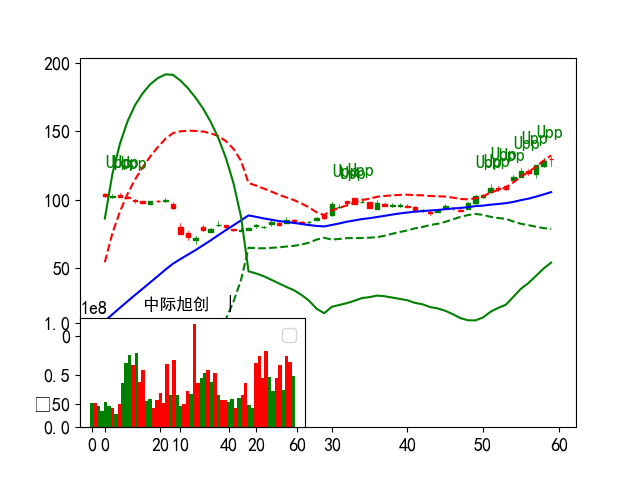

300689 1.7
xratio:0.25 ra_diff:1.7
code: 300689


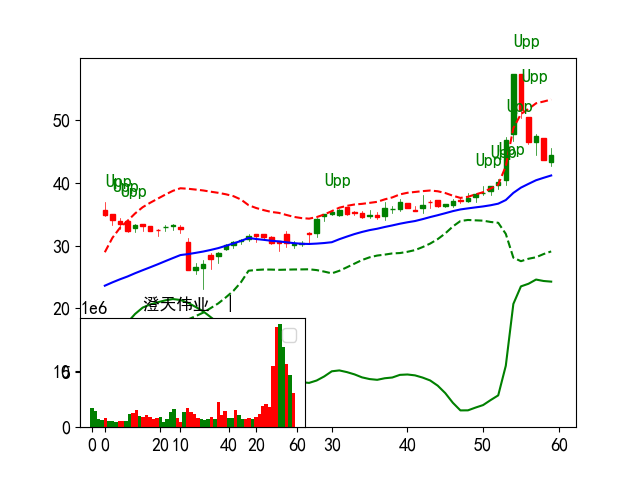

002940 2.58
xratio:0.21 ra_diff:2.58
code: 002940


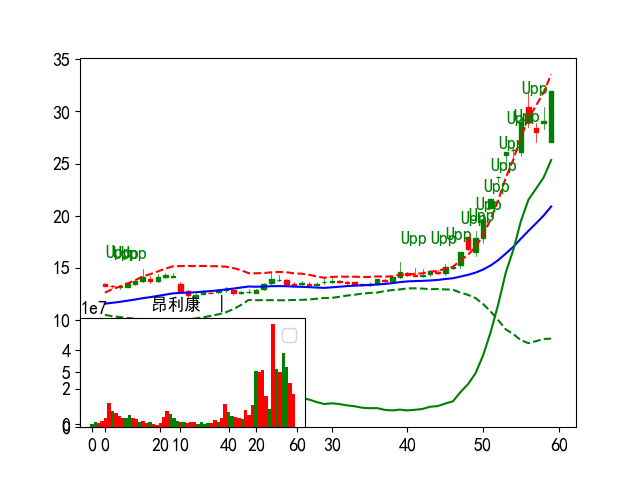

603657 2.32
xratio:0.29 ra_diff:2.32
code: 603657


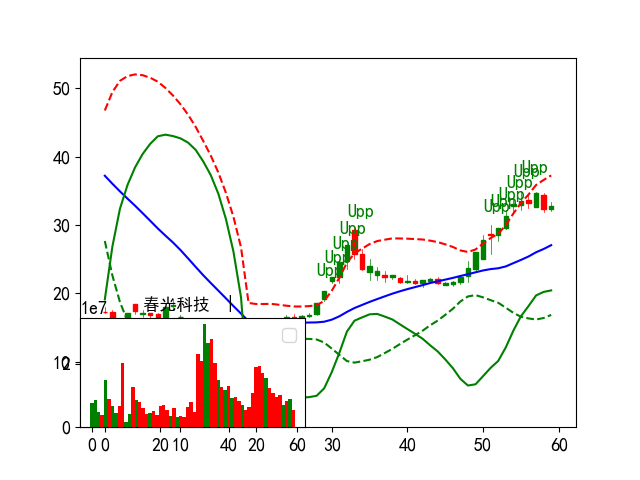

002826 2.73
xratio:0.17 ra_diff:2.73
code: 002826


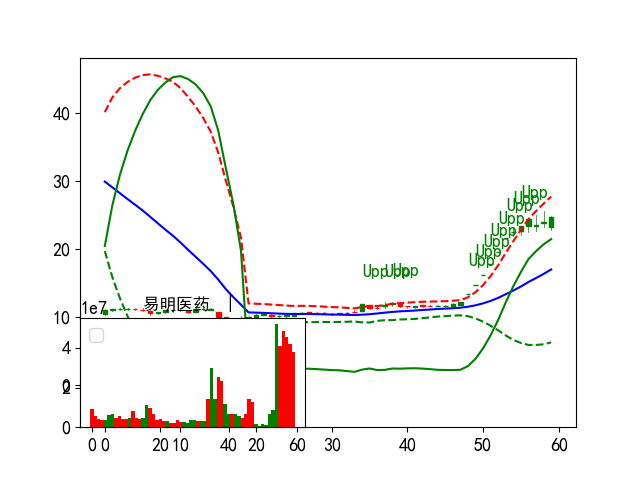

300468 2.58
xratio:0.28 ra_diff:2.58
code: 300468


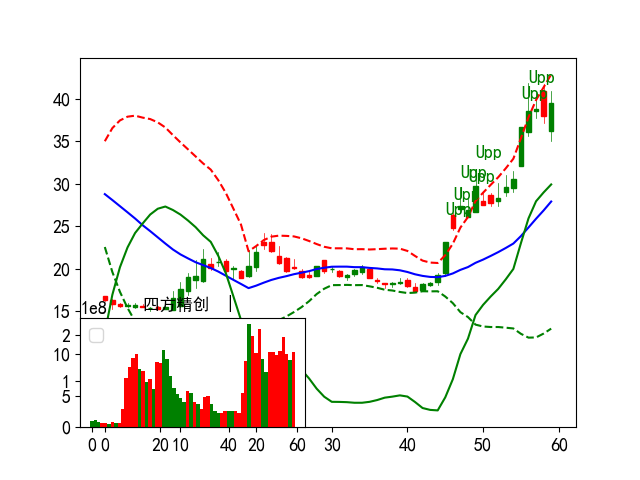

301155 1.25
xratio:0.11 ra_diff:1.25
code: 301155


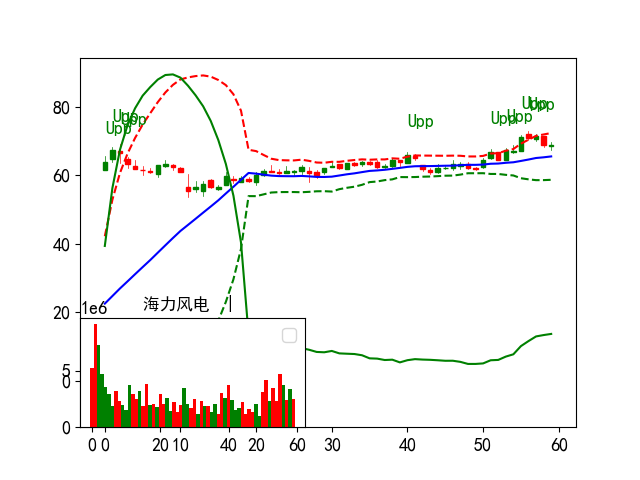

002827 1.41
xratio:0.14 ra_diff:1.41
code: 002827


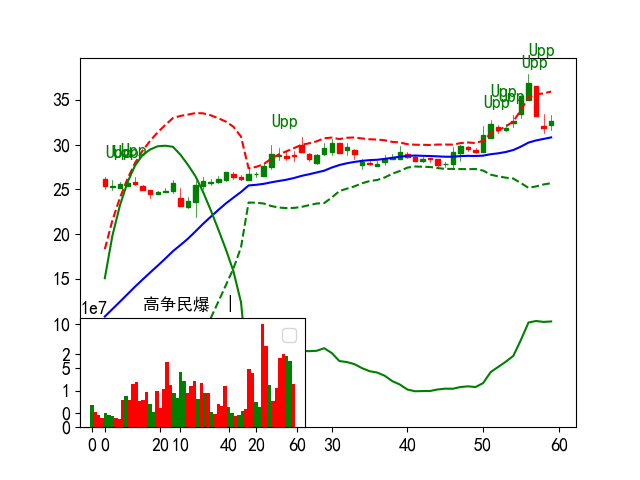

600113 1.64
xratio:0.04 ra_diff:1.64
code: 600113


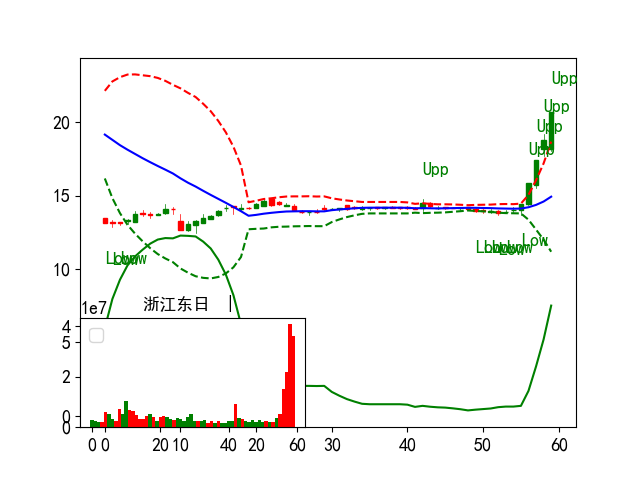

300085 1.27
xratio:0.05 ra_diff:1.27
code: 300085


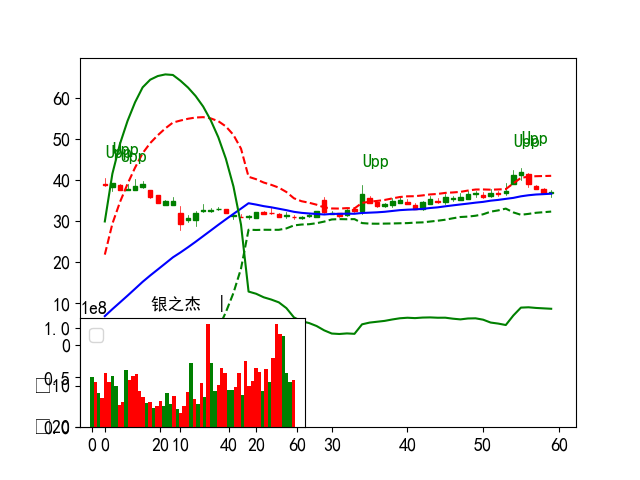

In [114]:
print("df_mask250:%s"%(len(df_mask250.query('couts > 1 and perc > 0'))))
for co in df_mask250.query('couts > 1 and perc > 0').index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Tail1 Show Top 主升浪df_masklastd

In [91]:
df_mask250[(df_mask250.date >= lastday_week)][:2]
df_mask250[df_mask250.ra_diff > 1.3].shape

date   lopen   lhigh    llow   close         vol        amount  \
code                                                                          
603129 2025-06-13  212.50  220.50  210.75  212.38   2490991.0  5.405252e+08   
300308 2025-06-16  116.88  123.38  116.88  129.50  59369856.0  7.204022e+09   

        ra_diff    ma10     ma5  ...    idx  couts  nclose  name    open  \
code                             ...                                       
603129     1.58  198.10  208.87  ...  34.50      1  212.75  春风动力  211.75   
300308     1.68  105.05  112.31  ...  27.06      2  128.38  中际旭创  130.00   

          high     low  llastp            ticktime  perc  
code                                                      
603129  215.00  210.75  211.75 2025-06-22 15:00:01  0.30  
300308  131.12  124.75  128.25 2025-06-22 16:34:30  0.97  

[2 rows x 41 columns]

(149, 41)

In [92]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
if resample.upper() =='D':
    df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 10) & (df_mask250.close > df_mask250.ma5) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )
else:
    df_masklastd = df_mask250[(df_mask250.date >= lastday_week) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 20) & (df_mask250.close > df_mask250.ma5) )
                          ]
# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]

#当下大于上轨
df_masklastd = df_masklastd[df_masklastd.close > df_masklastd.ma5]

print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


if resample.upper() =='M':
    df_masklastd = df_masklastd.sort_values(
        by=['perc1d', 'perc3d'],
        ascending=[0, 0])
else:
    df_masklastd = df_masklastd.sort_values(
        by=['perc3d', 'perc1d'],
        ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

# show_tdx_data(df_masklastd)
print(df_masklastd.name.T[:20])
# show_tdx_data(df_masklastd[-10:])


code_t = '300675'
code_t = '605268'
code_t = '002828'
code_t = '300418'
code_t = df_masklastd.index[0]


# df_masklastd.loc[code_t, ['name', 'couts',
#                           'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


# show_tdx_data(df_masklastd.loc[code_t])

src:(224, 41)  lastd:(23, 41) 
code
301176    逸豪新材
601606    长城军工
002579    中京电子
600113    浙江东日
300483    首华燃气
300589    江龙船艇
301132    满坤科技
301200    大族数控
002805    丰元股份
605298    必得科技
601869    长飞光纤
301040    中环海陆
000985    大庆华科
600367    红星发展
600876    凯盛新能
600378    昊华科技
300985    致远新能
002555    三七互娱
002983     芯瑞达
300373    扬杰科技
Name: name, dtype: object


### !!! df_mask_hmax 061

df_mask_hmax:99
002940 2.58
xratio:0.21 ra_diff:2.58
code: 002940


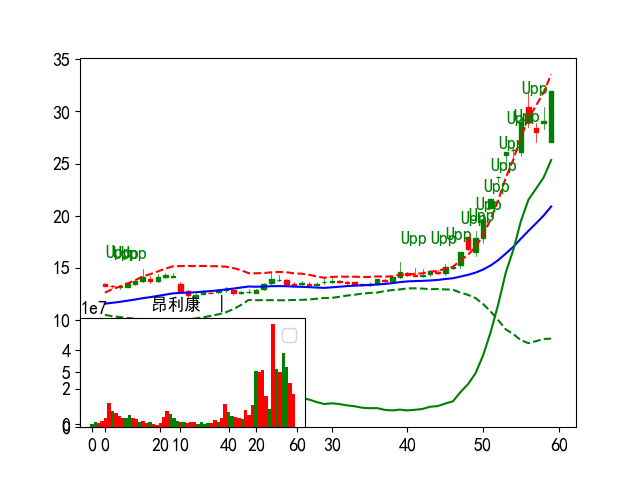

003040 2.11
xratio:0.1 ra_diff:2.11
code: 003040


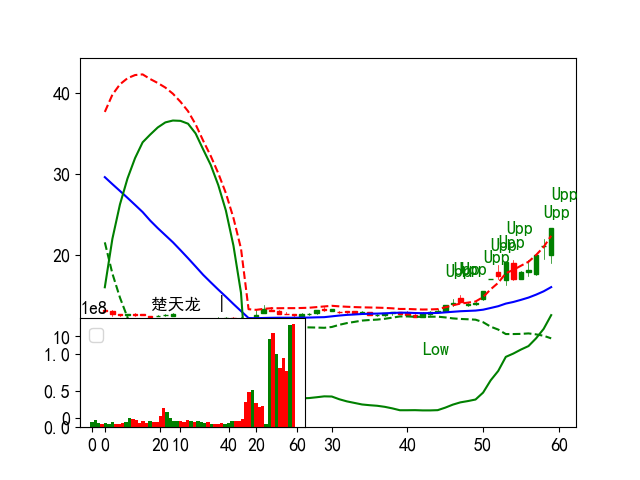

600919 1.28
xratio:0.04 ra_diff:1.28
code: 600919


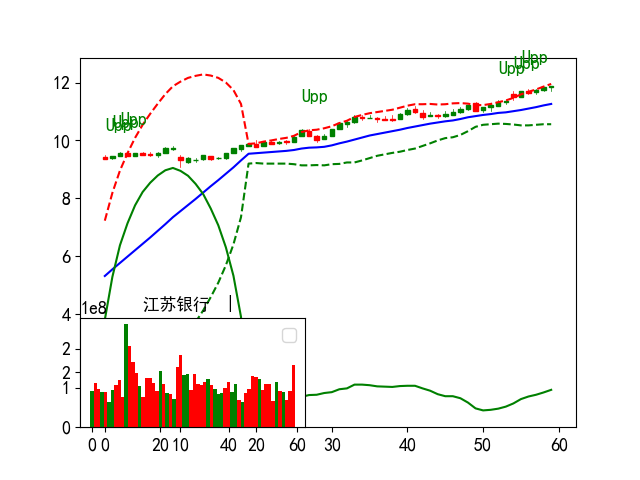

300308 1.8
xratio:0.43 ra_diff:1.8
code: 300308


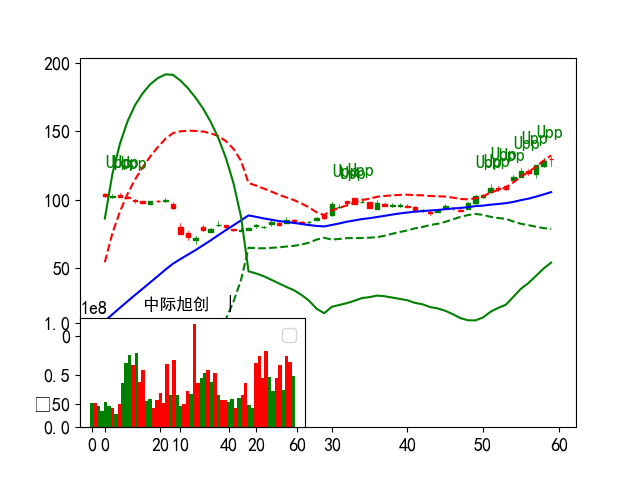

600000 1.35
xratio:0.05 ra_diff:1.35
code: 600000


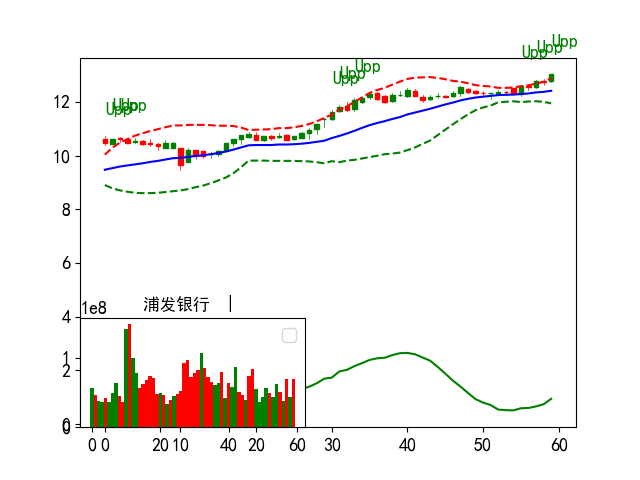

000159 1.43
xratio:0.01 ra_diff:1.43
code: 000159


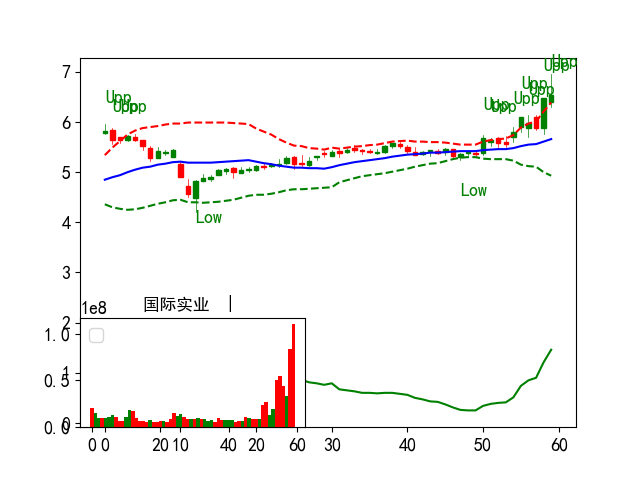

601169 1.16
xratio:0.01 ra_diff:1.16
code: 601169


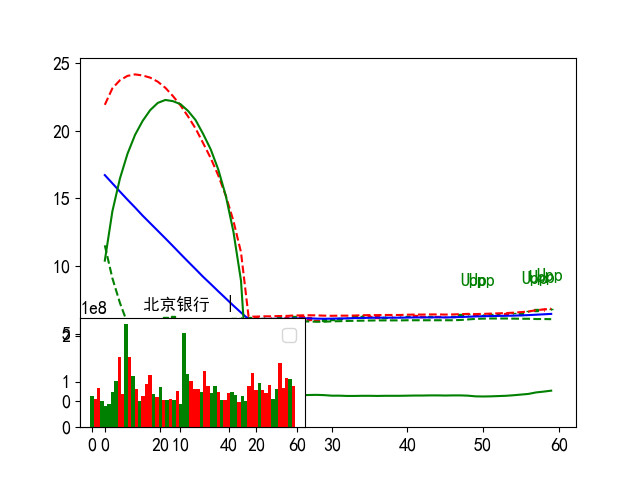

300340 2.58
xratio:0.11 ra_diff:2.58
code: 300340


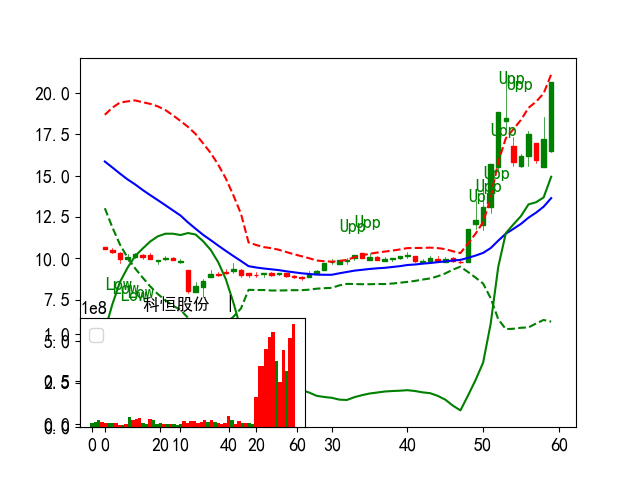

002207 1.99
xratio:0.04 ra_diff:1.99
code: 002207


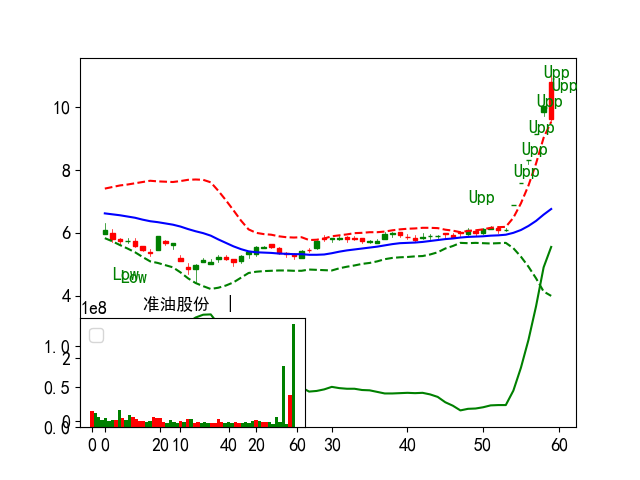

000968 1.37
xratio:0.01 ra_diff:1.37
code: 000968


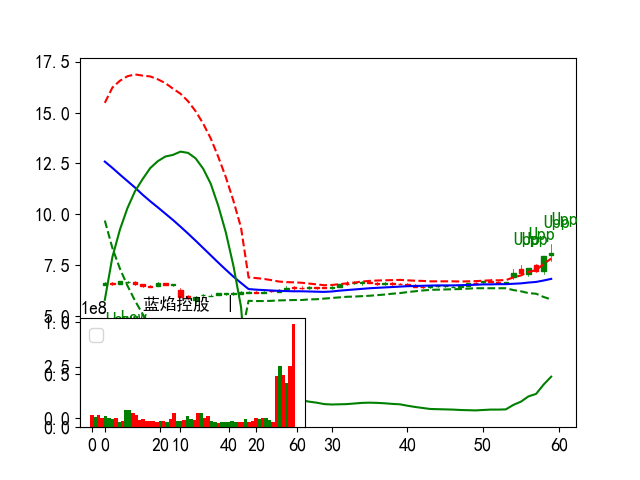

In [93]:
print("df_mask_hmax:%s"%(len(df_mask_hmax)))
for co in df_mask_hmax.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

###  df_masklastd 068
    show_ohlc_upper(dfs.loc[co][-60:])

df_masklastd:23
301176 1.5
xratio:0.2 ra_diff:1.5
code: 301176


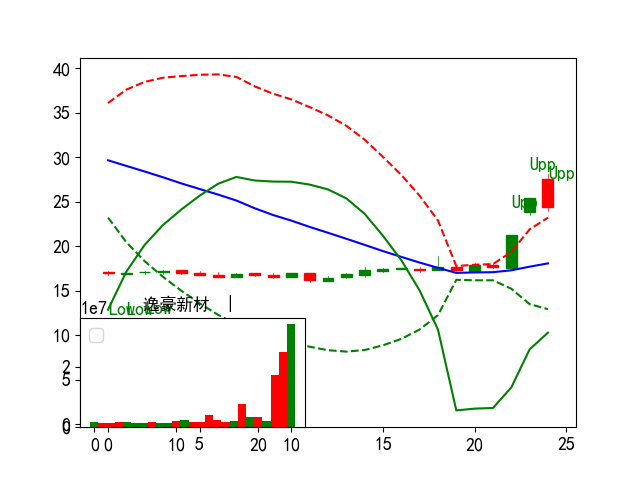

601606 1.7
xratio:0.05 ra_diff:1.7
code: 601606


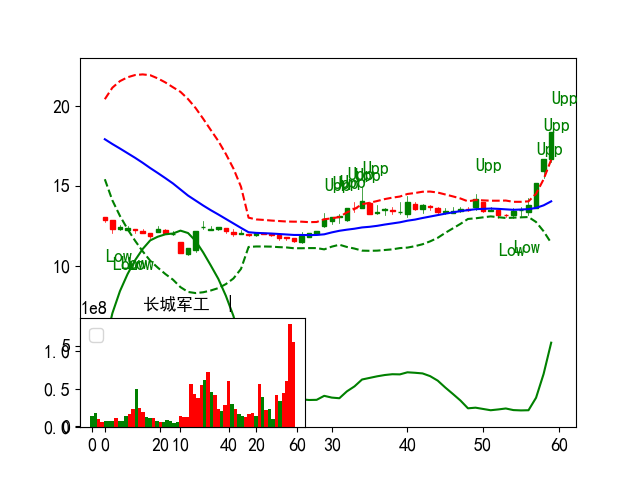

002579 1.67
xratio:0.02 ra_diff:1.67
code: 002579


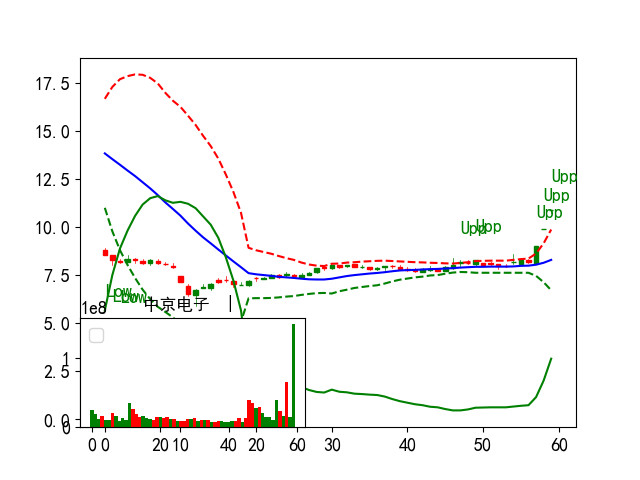

600113 1.64
xratio:0.04 ra_diff:1.64
code: 600113


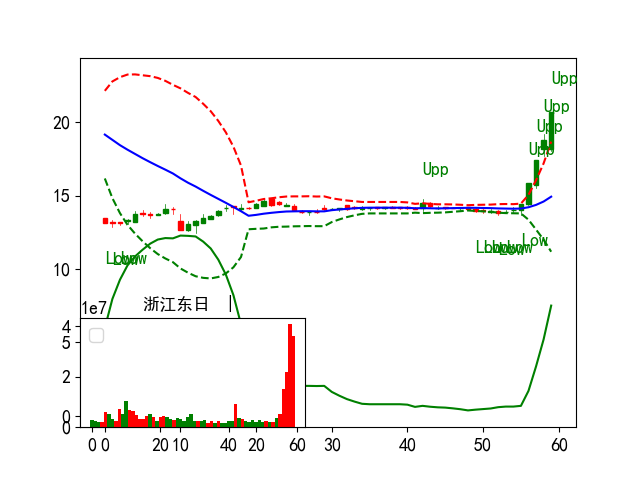

300483 2.19
xratio:0.05 ra_diff:2.19
code: 300483


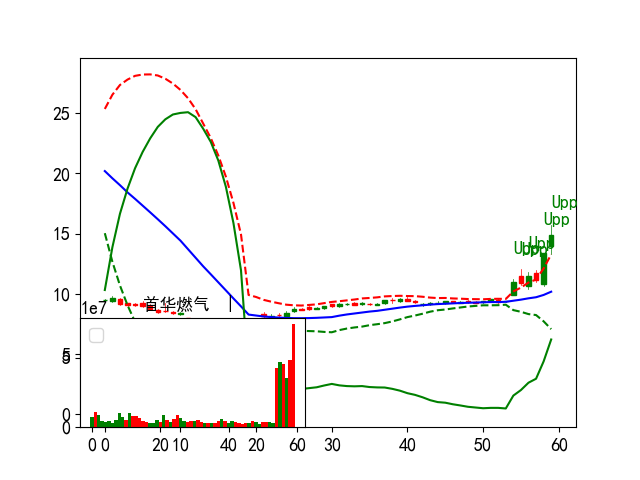

300589 1.5
xratio:-0.02 ra_diff:1.5
code: 300589


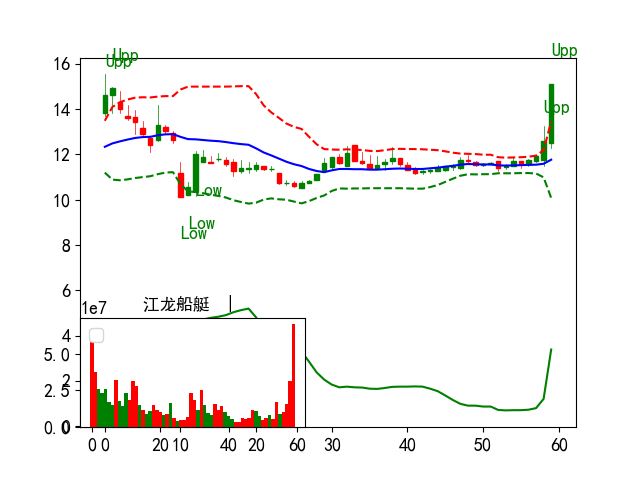

301132 1.61
xratio:0.08 ra_diff:1.61
code: 301132


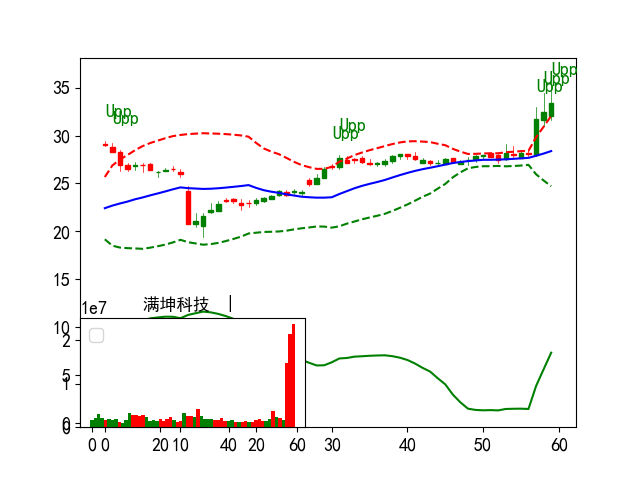

301200 1.29
xratio:-0.02 ra_diff:1.29
code: 301200


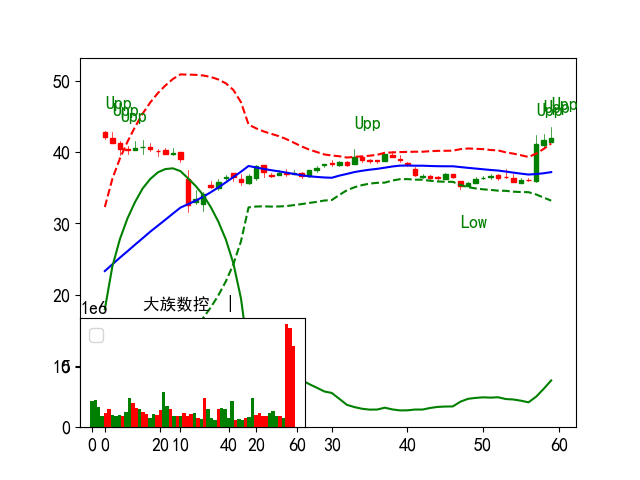

002805 1.29
xratio:0.01 ra_diff:1.29
code: 002805


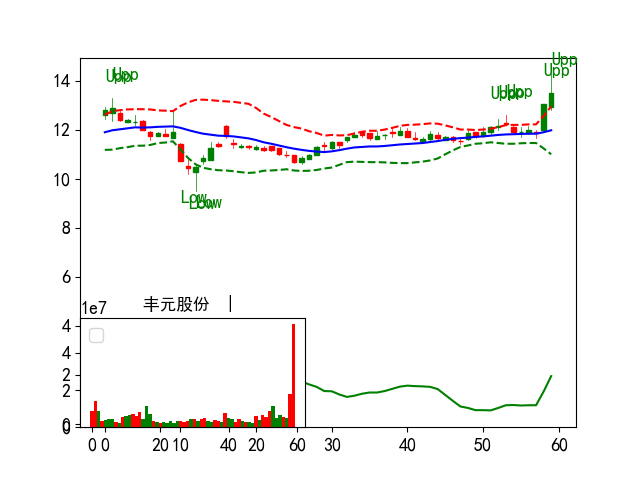

605298 1.3
xratio:-0.01 ra_diff:1.3
code: 605298


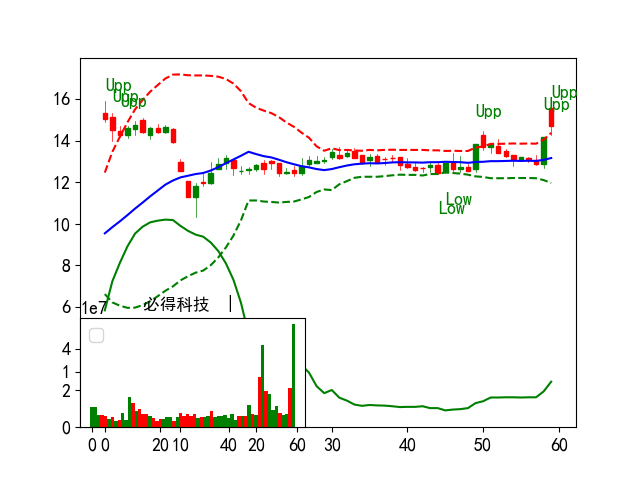

In [94]:
print("df_masklastd:%s"%(len(df_masklastd)))
for co in df_masklastd.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Cross_hmax_250 068

In [103]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250],limit=5)

cross_hamx:19
Count:19 41


name  couts       date   perc  ra_diff  xratio   idx    hat  close  \
code                                                                         
301176  逸豪新材      1 2025-06-20  -4.20     1.50    0.21  6.97  10.29  24.41   
601606  长城军工      2 2025-06-20  10.01     1.70    0.09  4.96   5.20  18.36   
002579  中京电子      1 2025-06-20   9.99     1.67    0.07  2.84   3.16  10.90   
600113  浙江东日      3 2025-06-20   9.99     1.64    0.14  6.75   7.50  20.69   
300483  首华燃气      1 2025-06-20  10.99     2.19    0.14  5.45   6.21  14.85   

        volsum5d  ...  ma250  nclose   llow   vol1d   vol2d   vol3d   vol4d  \
code              ...                                                         
301176     737.1  ...  23.18   25.75  24.02   37.66   45.04  689.69  -32.77   
601606     155.0  ...  10.53   18.12  16.50  -17.43  125.62   32.60   32.22   
002579    1035.9  ...  10.08   10.90  10.72  884.27  -76.49  299.86  -31.33   
600113     358.1  ...  11.76   19.38  18.00  -12.22   86.66   43.46  189.63   
300483      75.3  ...  12.74   14.76  13.31   53.94   37.77  -23.25   -3.11   

        vol5d  perc3d  perc5d  
code                           
301176  -2.57   37.99   41.10  
601606 -18.02   33.14   37.01  
002579 -40.40   33.09   32.93  
600113  50.54   30.54   47.79  
300483   9.97   29.58   35.00  

[5 rows x 24 columns]

df_mask250:19
605298 1.3
xratio:-0.01 ra_diff:1.3
code: 605298


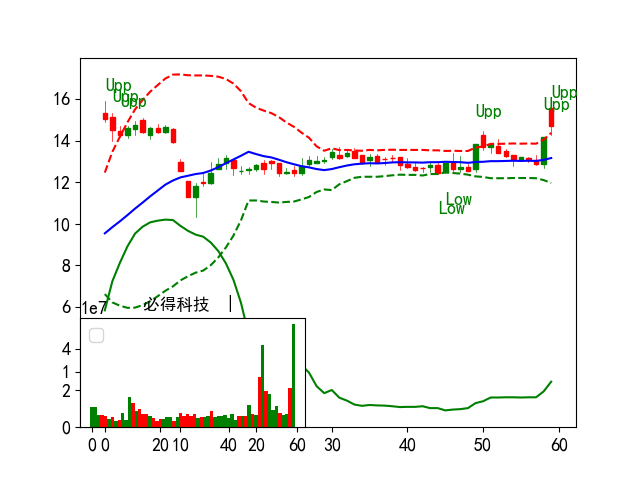

601869 1.29
xratio:0.04 ra_diff:1.29
code: 601869


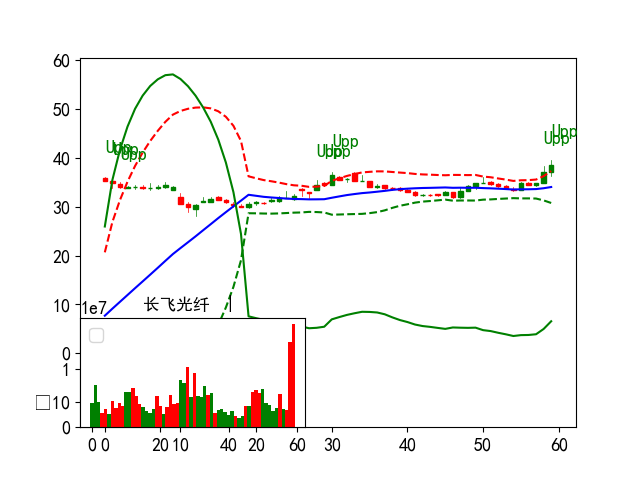

301040 2.09
xratio:0.18 ra_diff:2.09
code: 301040


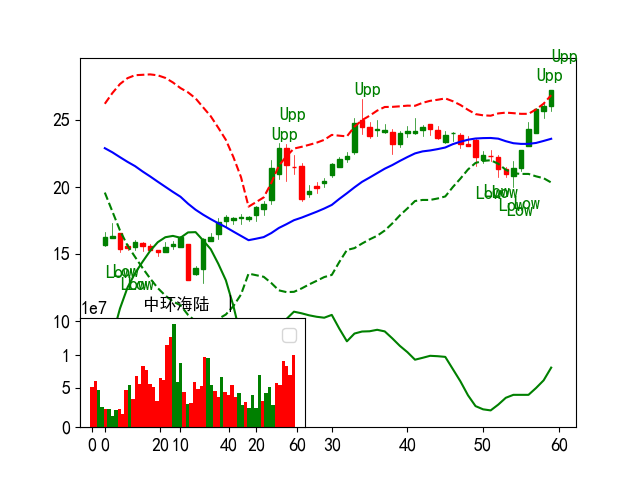

000985 1.36
xratio:0.03 ra_diff:1.36
code: 000985


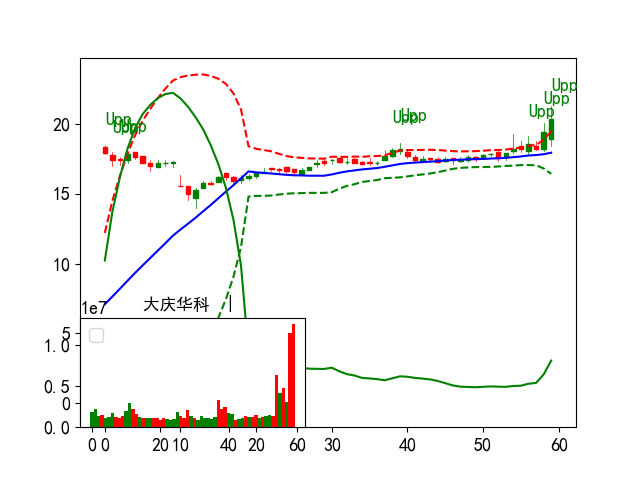

600367 1.33
xratio:-0.0 ra_diff:1.33
code: 600367


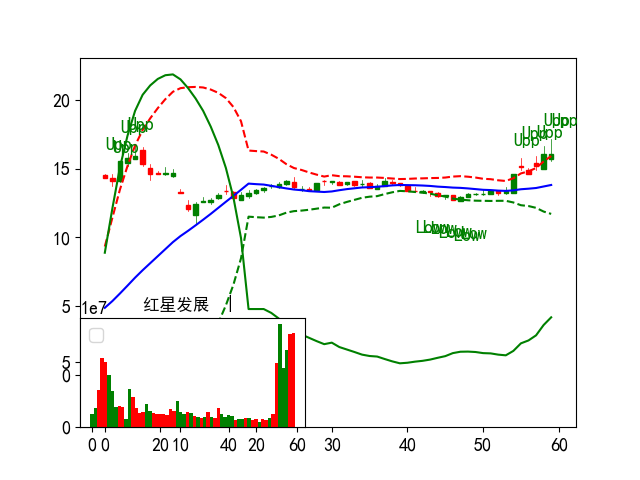

600876 1.27
xratio:0.0 ra_diff:1.27
code: 600876


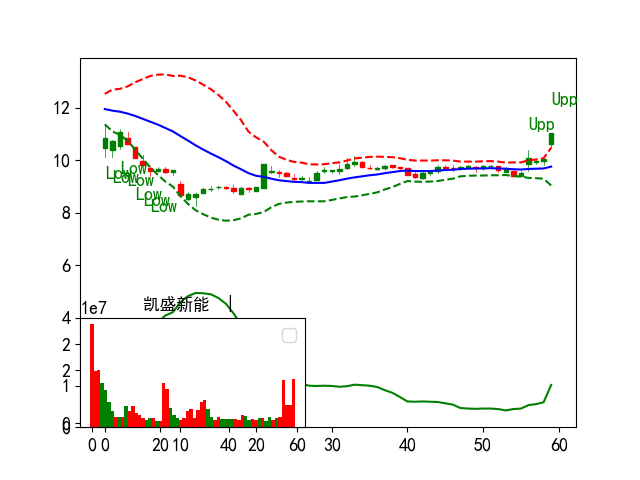

600378 1.12
xratio:-0.06 ra_diff:1.12
code: 600378


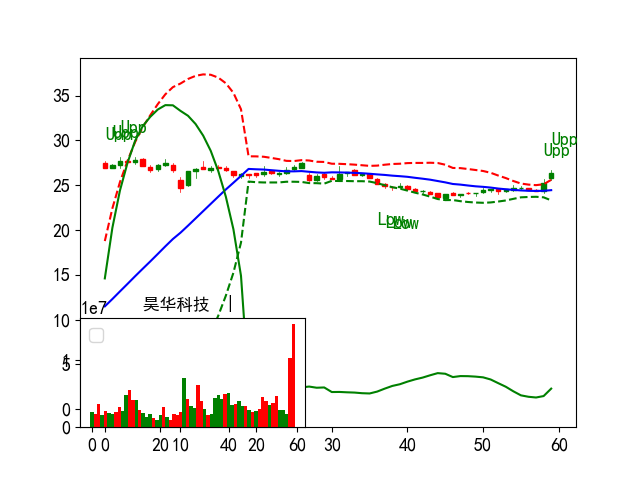

300985 1.34
xratio:0.01 ra_diff:1.34
code: 300985


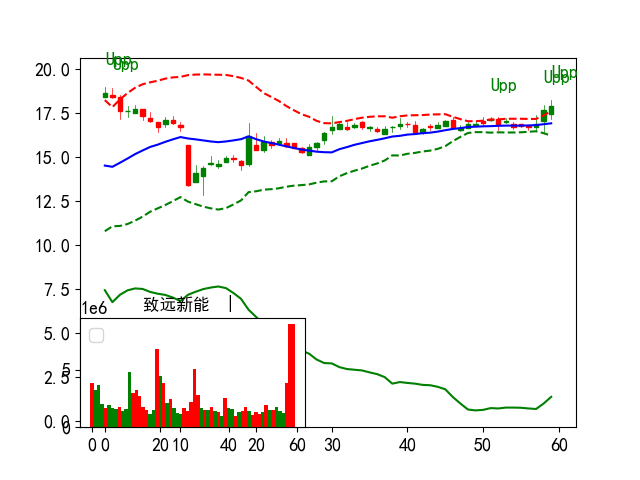

002983 1.38
xratio:0.07 ra_diff:1.38
code: 002983


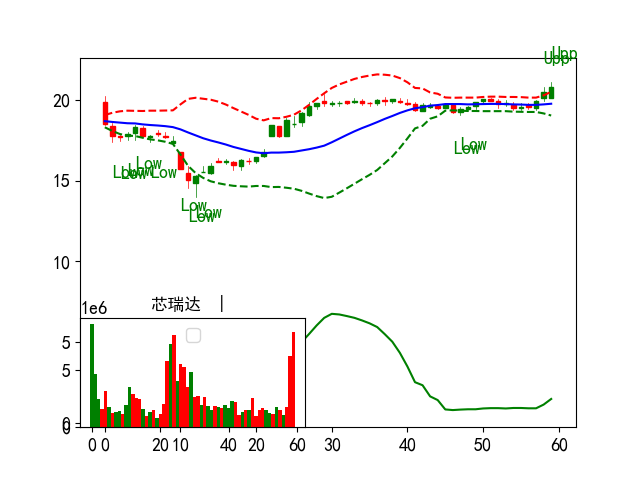

002270 1.31
xratio:0.03 ra_diff:1.31
code: 002270


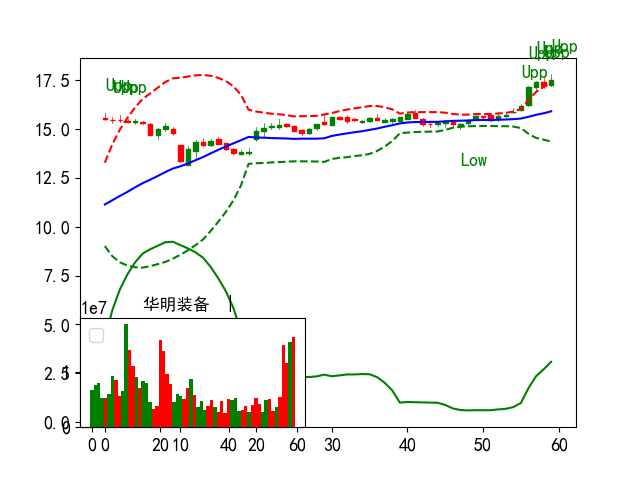

In [96]:
print("df_mask250:%s"%(len(cross_hmax_250)))
# dfs.loc['000002'].shape
for co in cross_hmax_250[-10:]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

## 写入061

In [97]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)].index.tolist()
hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) ].index.tolist()

# write_code_to_blk(cross_hmax_250,'068')
# write_code_to_blk(hmax_code,'061')

In [98]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [99]:
top_temp.shape
top_temp.index

(216, 34)

Index(['688668', '603373', '601009', '301369', '301345', '300476', '002352',
       '300804', '601838', '601808',
       ...
       '300263', '600113', '300505', '603800', '688291', '300056', '002826',
       '002017', '300502', '688502'],
      dtype='object', name='code', length=216)

## plt.close('all')

In [100]:
# plt.close('all')

# 写入060